# 1. Giới thiệu tổng quan

## Đặt vấn đề

- **Mục tiêu** : Trong báo cáo này, mục tiêu chính của nhóm là xây dựng mô hình dự đoán giá của điện thoại dựa trên các đặc tính của sản phẩm điện thoại đó

- **Bài toán** : Hiện nay thị trường điện thoại đang bùng nổ với nhiều công nghệ mới và số lượng sản phẩm ra mắt hàng năm ngày một lớn. Người dùng ngày nay càng có nhiều sự lựa chọn hơn và họ luôn mong muốn mua được sản phẩm tốt nhất với giá thấp nhất. Bên cạnh đó, những nhà sản xuất điện thoại cũng luôn mong muốn đưa ra thị trường những sản phẩm có giá phù hợp nhất với thị trường để tăng sức cạnh tranh so với các sản phẩm khác. Xuất phát từ những nhu cầu đó, nếu có một hệ thống có khả năng dự đoán giá của điện thoại dựa trên đặc tính( kích thước màn hình, dung lượng bộ nhớ, ...) sẽ giúp người tiêu dùng và nhà sản xuất có thể đưa ra quyết định một cách hợp lý và chính xác nhất

In [ ]:
import pandas as pd
import requests
import bs4
import numpy as np
import time , os, json, re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

## Mục lục

- Bài báo cáo này bao gồm các phần chính như sau :


1.   **Chuẩn bị dữ liệu**: Phần này chủ yếu mô tả các bước thực hiện cho việc thu thập dữ liệu bao gồm: lựa chọn nguồn thu thập, cách thu thập dữ liệu và tổng quan về dữ liệu thô thu thập được của bài toán
2.   **Xử lý dữ liệu**: Từ tập dữ liệu thô, thực hiện các bước làm sạch dữ liệu, trích xuất thông tin, xử lý với dữ liệu missing
3.   **Phân tích dữ liệu**: Sau khi dữ liệu được xử lý, thực hiện phân tích dữ liệu với mục đích tìm kiếm đặc trưng của dữ liệu theo giá của sản phầm
4.   **Lựa chọn mô hình**: Phần này sẽ bao gồm các bước chuẩn hóa dữ liệu, chia dữ liệu và thực nghiệm trên các mô hình khác nhau để lựa chọn mô hình phù hợp nhất cho bài toán.
5.   **Tối ưu mô hình**: Sau khi lựa chọn được mô hình phù hợp, thực hiện các phương pháp lựa chọn siêu tham số cho bài toán
6.   **Đánh giá kết quả và giải thích**: Đưa ra đánh giá, kiểm thử của mô hình trên tập test, từ đó đưa ra kết luận và giải thích kết quả  
7.   **Thảo luận**: Các vấn đề mà mô hình đang gặp phải


# 2. Chuẩn bị dữ liệu

## Tìm kiếm nguồn dữ liệu
- Với bài toán trên, ban đầu cần tìm kiếm các nguồn dữ liệu bao gồm các đặc điểm của điện thoại, kèm theo giá bán của chúng. Dựa vào đó, nhóm đã tìm kiếm và liệt kê ra một số trang web bán điện thoại lớn tại việt nam như sau:


1.   [CellphoneS](https://cellphones.com.vn/)
2.   [Thế giới di động](https://www.thegioididong.com/dtdd)
3.   [FPT shop](https://fptshop.com.vn/)
</br> =>  Tuy nhiên những trang web trên thường có dữ liệu ít (200 ~ 300 sản phẩm) đồng thời chỉ bán các hãng điện thoại tại Việt Nam, do đó việc thu thập dữ liệu từ nguồn này là chưa phù hợp

- Nhóm cũng đã tìm thêm các trang web chứa thông tin điện thoại nước ngoài có sẵn như sau:
1. [PhoneDb](https://phonedb.net/)
2. [Phonearena](https://www.phonearena.com/database)
3. [GSMArena](https://www.gsmarena.com/)

</br> => Sau khi so sánh, về cơ bản dữ liệu tại 3 trang web trên khá tương đồng nhau, tuy nhiên dữ liệu tại PhoneDb không phù hợp khi kết quả tìm kiếm thường trả về nhiều phiên bản điện thoại bị trùng lặp nhau (thu thập và xử lý mất thời gian). Dữ liệu tại Phonearena chỉ có đặc trưng điện thoại mà chưa có giá bán của nó. Dữ liệu tại GSMArena có giá điện thoại và chia theo từng hãng, tuy nhiên giá điện thoại lại theo nhiều đơn vị tiền tệ khác nhau.
- Dựa vào kết quả phân tích nguồn dữ liệu như trên, nhóm lựa chọn thu thập dữ liệu từ trang web GSMArena

## Thực hiện thu thập dữ liệu
- Nhóm sử dụng các thư viện Beautifulsoup, selenium trong ngôn ngữ Python để thu thập dữ liệu



In [ ]:
class GMSarena_crawler :
    """
    Khởi tạo nhận brand và id của brand
    - Lưu đường dẫn htmlr
    - Lưu đường dẫn tới file lưu

    """
    def __init__(self, brand: str, brand_id: int):
        self.brand = brand
        self.brand_id = brand_id
        self.path = "https://www.gsmarena.com/" + brand + "-phones-" + str(brand_id) + ".php"
        self.save_path = ""
        self.feature = ['Model', 'Brand',  'Launch Status', 'Body Dimensions', 'Body Build', 'Body Weight', 'Body SIM', 'Display Type', 'Display Size', 'Display Resolution', 'Platform OS', 'Platform Chipset',
                        'Memory Internal', 'Main Camera', 'Selfie camera Single', 'Sound Loudspeaker', 'Sound 3.5mmjack', 'Battery Charging', 'Battery Type','Comms Bluetooth', 'Misc Colors', 'Features Sensors' ,'Misc Price']
        self.df = pd.DataFrame(columns= self.feature)
        self.is_stop_crawl = False

    """Dùng để crawl thông tin của một trang, trả về đối tương soup """
    def crawl_page(self,  link):
        header = {'User-agent': 'Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/64.0.3282.186 Safari/537.36'}
        time.sleep(np.random.randint(low = 10, high = 20))

        try:
            page = requests.get(link, timeout=5, headers= header)

            soup = bs4.BeautifulSoup(page.text, "html.parser")

            return soup

        except ConnectionError as err :
            print("Connection Error!")
            exit()

        except Exception as err :
            print("Error!")
            exit()


    """Hàm này crawl các đường link của từng model trong trang gốc"""
    def crawl_model_link(self, soup):
        models = soup.find_all(attrs={"class" : 'makers'})
        href_val = []

        list_a = models[0].find_all('a')

        if list_a == None : return None
        for a in list_a:
            href_val.append(a['href'])

        return href_val




    """Hàm này crawl thông tin của một điện thoại"""
    def crawl_model(self, href_val):

        for i in href_val :
            soup = self.crawl_page('https://www.gsmarena.com/' + i)
            if soup == None : continue
            # soup = self.test_soup("Samsung Galaxy C55 - Full phone specifications.html")
            spec_list = soup.find_all(attrs = {"id" : 'specs-list'})
            self.crawl_spec_table(spec_list[0], i)


    """ Hàm này crawl dữ liệu spec của 1 model """
    def crawl_spec_table(self, spec_list, model):
        specs = {key : None for key in self.feature}
        specs['Model'] = model
        specs['Brand'] = self.brand
        tables = spec_list.find_all('table')




        for table in tables :
            ttl_a_tags = table.find_all('td', class_='ttl')
            nfo_a_tags = table.find_all('td', class_='nfo')


            pre_key = table.find('th').get_text()
            for i in range(min(len(ttl_a_tags), len(nfo_a_tags))):

                key = ttl_a_tags[i].get_text().replace(" ", "")

                val = nfo_a_tags[i].get_text()
                if pre_key == 'Main Camera' :
                    if key == 'Dual' :
                      specs['Main Camera'] = 2
                      continue
                    elif key == 'Single':
                      specs['Main Camera'] = 1
                      continue
                    elif key == 'Triple' :
                      specs['Main Camera']  = 3
                      continue
                    elif key == 'Quad' :
                      specs['Main Camera'] = 4
                      continue


                key = pre_key + ' ' + key
                # print(f'Val: {val}')
                # print(f'Key: {key}')

                if key not in  self.feature : continue



                specs[key] = val

        print(specs)

        self.df = pd.concat([self.df, pd.DataFrame([specs])], ignore_index=True)



    """ Hàm này save dữ liệu xuống file """
    def save(self, id: int):
        # self.df.to_csv('Raw-Data/' + self.brand + '.csv')
        self.df.to_csv('/content/drive/My Drive/' + self.brand + str(id) + '.csv' , index=False)


    def crawl_all_raw_data(self):
      # check this variable
        i = 1
        while i <= 30 :
            path = "https://www.gsmarena.com/" + self.brand + "-phones-f-" + str(self.brand_id) + '-0-p' + str(i) + ".php"
            soup_page = self.crawl_page(path)
            href_val = self.crawl_model_link(soup_page)
            if href_val == None :
                break
            self.crawl_model(href_val)
            i += 1
        self.df.info()
        self.save(0)


    def crawl_single_data(self, index: int):
        path = "https://www.gsmarena.com/" + self.brand + "-phones-f-" + str(self.brand_id) + '-0-p' + str(index) + ".php"
        soup_page = self.crawl_page(path)
        href_val = self.crawl_model_link(soup_page)
        if href_val == None : return

        self.crawl_model(href_val)
        self.df.info()
        self.save(index)

    def crawl_price_data(self, path : str):
        result = {}
        lst = path.split('-')
        if len(lst) != 2 : return None
        path = "https://www.gsmarena.com/" + lst[0] + '-price-'+ lst[1]
        soup_page = self.crawl_page(path)

        price_specs = soup_page.find(attrs={'class' : 'pricing-container'})
        if price_specs == None : return None
        table = price_specs.find('table')

        if table == None : return None
        result['caption'] = table.caption.text

        all = table.find_all('tr')
        if len(all) < 2 : return None
        label = all[0].find_all('th')
        val = all[1].find_all('td')
        print(label)
        print(val)

        for i in range(1, len(label)) :
            result[label[i].text] = val[i-1].text


        return result



    def test(self):
        # soup_page = self.crawl_page(self.path)
        # href_val = self.crawl_model_link(soup_page)
        href_val = ['samsung_galaxy_c55-12945.php']
        self.crawl_model(href_val)

    def test_soup(self, path):
        with open(path, 'r',  encoding='utf-8') as file :
            html_content = file.read()
        soup = bs4.BeautifulSoup(html_content, 'html.parser')
        return soup


- Nhóm đã thiết kế để một class riêng cho việc thu thập dữ liệu của trang web GSMArena, với đầu vào là tên của brand và id là id của brand đó trên trang web này.
- Toàn bộ dữ liệu thu thập được tại [đây](https://drive.google.com/drive/folders/1_jgYeJVP-nzvK5uHavRPEh6aYbsO9jg2)
- Sau khi hoàn tất thu thập dữ liệu, một hàng của dữ liệu thô có dạng như sau:


```
{
  "Model": "apple_ipad_pro_13_(2024)-12987.php",
  "Brand": "apple",
  "Launch Status": "Coming soon. Exp. release 2024, May 15",
  "Body Dimensions": "281.6 x 215.5 x 5.1 mm (11.09 x 8.48 x 0.20 in)",
  "Body Build": "Glass front, aluminum back, aluminum frame",
  "Body Weight": "579 g (Wi-Fi), 582 g (5G) (1.28 lb)",
  "Body SIM": "eSIM",
  "Display Type": "Ultra Retina Tandem OLED, 120Hz, HDR10, Dolby Vision, 1000 nits (HBM), 1600 nits (peak)",
  "Display Size": "13.0 inches, 527.3 cm2 (~86.9% screen-to-body ratio)",
  "Display Resolution": "2064 x 2752 pixels, 4:3 ratio (~264 ppi density)",
  "Platform OS": "iPadOS 17.5",
  "Platform Chipset": "Apple M4",
  "Memory Internal": "256GB 8GB RAM, 512GB 8GB RAM, 1TB 16GB RAM, 2TB 16GB RAM",
  "Main Camera": "1",
  "Selfie camera Single": "12 MP, f/2.4, 122˚ (ultrawide)",
  "Sound Loudspeaker": "Yes, with stereo speakers (4 speakers)",
  "Sound 3.5mmjack": "No",
  "Battery Charging": "",
  "Battery Type": "Li-Po (38.99 Wh), non-removable",
  "Comms Bluetooth": "5.3, A2DP, LE, EDR",
  "Misc Colors": "Silver, Space Black",
  "Features Sensors": "Face ID, accelerometer, gyro, compass, barometer",
  "Misc Price": "About 1550 EUR"
}

```



- Toàn bộ dữ liệu được tổng hợp vào trong một file .csv duy nhất, thông tin dữ liệu thô thu thập được như sau:

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
raw_df = pd.read_csv('/content/drive/MyDrive/all_data.csv')

raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4266 entries, 0 to 4265
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Model                 4266 non-null   object 
 1   Brand                 4266 non-null   object 
 2   Launch Status         4266 non-null   object 
 3   Body Dimensions       4265 non-null   object 
 4   Body Build            2344 non-null   object 
 5   Body Weight           4266 non-null   object 
 6   Body SIM              4266 non-null   object 
 7   Display Type          4266 non-null   object 
 8   Display Size          4266 non-null   object 
 9   Display Resolution    4266 non-null   object 
 10  Platform OS           4194 non-null   object 
 11  Platform Chipset      4008 non-null   object 
 12  Memory Internal       4209 non-null   object 
 13  Main Camera           4088 non-null   float64
 14  Selfie camera Single  3860 non-null   object 
 15  Sound Loudspeaker    

# 3. Xử lý dữ liệu

## Làm sạch dữ liệu

- **Lọc dữ liệu**: vì dữ liệu thu thập trên trang web có chứa các điện thoại cũ, không còn được tiếp tục phát hành trên thị trường, dữ liệu này kèm theo giá của nó có thể làm cho việc dự đoán bị sai gây ra nhiễu. Ngoài ra nó không còn phản ánh đúng giá điện thoại trên thị trường, do đó nhóm loại bỏ các dữ liệu này

In [ ]:
avai_df =  raw_df[raw_df['Launch Status'].str.contains('Available')]
avai_df.reset_index(inplace=True)

avai_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4266 entries, 0 to 4265
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   index                 4266 non-null   int64  
 1   Model                 4266 non-null   object 
 2   Brand                 4266 non-null   object 
 3   Launch Status         4266 non-null   object 
 4   Body Dimensions       4265 non-null   object 
 5   Body Build            2344 non-null   object 
 6   Body Weight           4266 non-null   object 
 7   Body SIM              4266 non-null   object 
 8   Display Type          4266 non-null   object 
 9   Display Size          4266 non-null   object 
 10  Display Resolution    4266 non-null   object 
 11  Platform OS           4194 non-null   object 
 12  Platform Chipset      4008 non-null   object 
 13  Memory Internal       4209 non-null   object 
 14  Main Camera           4088 non-null   float64
 15  Selfie camera Single 

- Lấy dữ liệu năm từ cột 'Launch  Status' sau đó lọc dữ liệu theo năm. Tại đây, nhóm loại bỏ các dữ liệu từ trước năm 2019, để loại bỏ độ ảnh hưởng các những điện thoại đã được sản xuất những năm trước đó. Do dữ liệu của trang web nhiều sản phẩm không được cật nhật giá thường xuyên nên giá các điện thoại  được sản xuất từ lâu không được điều chỉnh sao cho phù hợp với thị trường hiện tại

In [ ]:
avai_df['Released'] = avai_df['Launch Status'].str.split('Released', expand = True)[1]
avai_df['Released'] = avai_df['Released'].str.split(',', expand = True)[0]
avai_df['Released'] = avai_df['Released'].astype(int)
avai_df = avai_df[avai_df['Released'] >= 2019]

- Tách các cột dimension của điện thoại

In [ ]:
def extract_dimension(dimension):
    if type(dimension) != str : return pd.Series([None, None, None])
    parts = dimension.split(" x ")
    if len(parts) == 1 :
      return pd.Series([None, None, None])

    length = parts[0]
    if 'Unfolded: ' in length :
      length = length.split(' ')[1]
    if 'mm' in length :
      length = length.split('mm')[0]


    width = parts[1]
    if 'Unknow' in width : width = None

    elif 'mm' in width :
      width = width.split('mm')[0]

    height = parts[2].split(' ')[0]
    if '-' in height :
      height = height.split('-')[1]

    if 'mm' in height :
      height = height.split('mm')[0]

    if '/' in height :
      height = height.split('/')[0]
    # height = np.where(parts[2].extract(r'(.*?)(?= mm)'))
    return pd.Series([length, width, height])

avai_df[['body_length', 'body_width', 'body_height']] = avai_df['Body Dimensions'].apply(lambda x : extract_dimension(x))


- Phân tách dữ liệu từ cột 'Body Dimensions' thành 3 cột đại diện cho kích thước điện thoại

In [ ]:
avai_df['body_length'] = avai_df['body_length'].astype(float)
avai_df['body_width'] = avai_df['body_width'].astype(float)
avai_df['body_height'] = avai_df['body_height'].astype(float)
avai_df.drop(['Body Dimensions'],  inplace = True, axis = 1)

- Phân tách pixel của màn hình thành các 2 cột theo từng chiều

In [ ]:
avai_df['Display Resolution'] = avai_df['Display Resolution'].str.split(' pixels', expand = True)[0]
avai_df[['pixel_on_height', 'pixel_on_width']] = avai_df['Display Resolution'].str.split(' x ', expand = True)
avai_df['pixel_on_height'] = avai_df['pixel_on_height'].replace('Unspecified', '0')
avai_df['pixel_on_width'] = avai_df['pixel_on_width'].replace(['Unspecified', None], '0')
avai_df['pixel_on_height'] = avai_df['pixel_on_height'].astype('int')
avai_df['pixel_on_width'] = avai_df['pixel_on_width'].astype('int')

- Trích xuất dữ liệu từ cột display theo loại màn hình và tần số quét

In [ ]:
def extract_display(displays):
    parts = displays.split(",")
    display = parts[0].strip()
    hz = 60
    for i in range(1,len(parts)) :
      if 'Hz' in parts[i] :
        hz = int(parts[i].split('Hz')[0])
        break

    return pd.Series([display, hz])

avai_df[['display_type', 'refresh_rate']] = avai_df['Display Type'].apply(extract_display)


- Thực hiện tách lấy ra kích thước màn hình theo đơn vị là inches, Trong tập dữ liệu có chứa đồng hồ thông minh và cả máy tính bảng, do đó, nhóm sử dụng thuộc tính kích thước màn hình này để lọc giá trị với 2 ngưỡng là 3 và 8  

In [ ]:
avai_df['Display Size'] = avai_df['Display Size'].str.split(' inches', expand = True)[0]
avai_df['display_size'] = avai_df['Display Size'].astype('float')
avai_df = avai_df[(avai_df['display_size'] > 3) & (avai_df['display_size'] < 8)]

- Tách dữ liệu chipset theo hãng chip và tiến trình của chip (nm)  

In [ ]:

avai_df['Platform Chipset'].dropna(inplace=True)
list_of_chipset = avai_df['Platform Chipset'].unique()


list_of_miss_nm = {'MediaTek MT8766B': 12, 'Mediatek MTK8768': None, 'Mediatek MT8788V': 12,
                   'Unisoc T117': None, 'Spreadtrum': None,'Allwinner A523': 22, 'Mediatek Helio G99': 6,
                   'Mediatek MT8788V/WA': 12, 'Unisoc T618': 12, 'Unisoc SC7731e': 28, 'RK3562': None,
                   'Realtek 8763EW': None, 'Realtek 8762DK': None, 'nRF52840': None, 'Realtek 8762C': None,
                   'nRF52832': None, 'Unisoc T107': None, 'Mediatek MT6762CB': None, 'Mediatek MT6739': 28,
                   'Mediatek MT6261D': None, 'Unisoc 6531E': None, 'Unisoc SC6531DA': None, 'Spreadtrum SC6531E': 28,
                   'Spreadtrum SC9820E': 28, 'Mediatek': None, 'Qualcomm 5100': 4, 'MediaTek MT8786': None,
                   'Mediatek MT8786': None, 'Qualcomm Snapdragon 778G+ 5G': 6, 'Mediatek MT8768T Helio P22T': 16,
                   'Kirin A1': None, 'Mediatek MT8768': None, 'Mediatek Helio G99 Ultimate': 6, 'Unisoc T700': None,
                   'Mediatek MT8166 - Wi-Fi versionMediatek MT8766 - LTE version': 12, 'Unisoc 6531F': None,
                   'Unisoc UMS9117': None, 'Mediatek MT6260A': None, 'Mediatek Dimensity 1200 Max': 6,
                   'Unisoc UMS9230': 12, 'Mediatek Helio G99 Ultra': 6, 'Mediatek MT6761WE': 16, 'Allwinner A133': None,
                   'Mediatek MT8766B': 12, 'Mediatek MT8771': None, 'Mediatek MT8768E': None, 'Mediatek MT8167': 28,
                   'Mediatek MT8766': 12, 'Qualcomm MSM8909W Snapdragon Wear 2100': 28, 'Apple S9': 4, 'Apple M2': None,
                   'Apple S8': 7, 'Apple M1': 5, 'Apple S7': None, 'Apple S5': None, 'Apple S6': None, 'Apple A12Z Bionic': 7}

# tách cột chipset thành 2 thành phần
def brand_chipset(s : str):
    s = s.lower()
    if 'apple' in s : return 'Apple'
    if 'mediatek' in s : return 'Mediatek'
    if 'snapdragon' in s or 'qualcomm' in s : return 'Qualcomm'
    if 'exynos' in s : return 'Samsung'
    if 'kirin' in s : return 'Huawei'
    if 'unisoc' in s : return 'Unisoc'

    return 'Other'


def exact_nm(s : str) :
    if 'nm' not in s :
        if s not in list_of_miss_nm.keys() : return None
        return list_of_miss_nm[s]

    pattern = r"\((\d+) nm[\+]?\)"
    match = re.search(pattern, s)
    if match :
        value_nm = match.group(1)
        return int(value_nm)
    return None
avai_df.dropna(subset=['Platform Chipset'], inplace= True, ignore_index=True)
avai_df['platform_chipset_brand'] =  avai_df['Platform Chipset'].apply(lambda x : brand_chipset(x))
avai_df['platform_chipset_nnm'] = avai_df['Platform Chipset'].apply(lambda x : exact_nm(x))

avai_df.drop(['Platform Chipset'], inplace = True, axis = 1)


- Chuyển đổi dữ liệu từ cột 'Selfie  camera Single'  sang kiểu số

In [ ]:
avai_df['Selfie camera Single'].fillna('0 MP', inplace=True)
pattern = r'\b(\d+(\.\d+)?)\s*MP\b'
avai_df['selfie_camera_quality'] = avai_df['Selfie camera Single'].str.extract(pattern)[0].astype(float)

- Trích xuất thông tin tốc độ sạc

In [ ]:
avai_df['Battery Charging'].fillna("5W", inplace=True)
def extract_charging_values(row):
    wired_value = 5
    wireless_value = 0

    if 'wired' in row:
        # Extract the wired value using regex
        wired_match = pd.Series(row).str.extract(r'(\d+W wired)')[0]
        if not wired_match.isnull().all():
            wired_value = int(wired_match.str.extract(r'(\d+)')[0].iloc[0])

    if 'wireless' in row:
        # Extract the wireless value using regex
        wireless_match = pd.Series(row).str.extract(r'(\d+W wireless)')[0]
        if not wireless_match.isnull().all():
            wireless_value = int(wireless_match.str.extract(r'(\d+)')[0].iloc[0])

    return pd.Series([wired_value, wireless_value])


avai_df[['charging_wired', 'charging_wireless']] = avai_df['Battery Charging'].apply(extract_charging_values)

- Trích xuất các thông tin về dung lượng pin, dấu vân tay, ...

In [ ]:
avai_df['battery_capacity'] = avai_df['Battery Type'].str.extract(r'(\d+)').astype(float)

In [ ]:

def extract_first_number(value):
    if value == 'Yes':
        return 5

    match = re.search(r'\d+\.\d+', value)
    if match:
        return float(match.group(0))

    return value

avai_df['bluetooth_version'] = avai_df['Comms Bluetooth'].apply(extract_first_number).astype(float)

In [ ]:
avai_df['Features Sensors'].fillna('', inplace=True)
avai_df['fingerprint'] = avai_df['Features Sensors'].str.contains('Fingerprint', case=False, na=False)

In [ ]:
def num_color(dimensions):
  if pd.isna(dimensions) : return pd.Series([None])
  dim = dimensions.split(',')
  return pd.Series([len(dim)])

avai_df['num_colors'] = avai_df['Misc Colors'].apply(num_color)

In [ ]:
avai_df['have_3.5_jack'] = avai_df['Sound 3.5mmjack'].str.contains('Yes', case=False, na=False)

In [ ]:
def weight(dimemsion) :
  dim =  dimemsion.split('g')
  if len(dim) == 1 : return pd.Series([None])
  if '/' in dim[0] : dim[0] = dim[0].split('/')[0]
  tmp = dim[0].split(' ')

  return pd.Series([float(tmp[0])])


avai_df['weight'] = avai_df['Body Weight'].apply(weight)

In [ ]:
def memory_internal(memory):
  if pd.isna(memory) : return pd.Series([None, None])
  memory = memory.split(',')
  if len(memory) == 0 : return pd.Series([None, None])
  memory = memory[0].split('GB')
  if len(memory) == 1 : return  pd.Series([None, None])
  ram = memory[1]
  me =  memory[0]
  if 'TB' in memory[0] :
    memory = memory[0].split('TB')
    me = float(memory[0]) * 1000
    ram = float(memory[1])
  if ram == '' : return  pd.Series([None, None])

  return pd.Series([float(ram), float(me)])

avai_df[['Ram', 'memory_internal']] = avai_df['Memory Internal'].apply(memory_internal)
avai_df['main_camera'] = avai_df['Main Camera'].astype(float)

In [ ]:
def extract_price(value):
    if value is np.nan:
        return np.nan

    # Nếu chuỗi chứa "$ {number}" và không chứa "C$"
    match_usd = re.search(r'\$\s*([\d,\.]+)', value)
    if match_usd and 'C$' not in value:
        usd_value = float(match_usd.group(1).replace(',', ''))  # Loại bỏ dấu phẩy
        return usd_value

    # Nếu chuỗi bắt đầu bằng "About {number} EUR"
    match_eur = re.match(r'^About (\d+) EUR', value)
    if match_eur:
        eur_value = float(match_eur.group(1))
        return eur_value * 1.082  # Chuyển đổi EUR sang USD

    # Nếu chuỗi có dạng "€  {number}"
    match_other_eur = re.search(r'€\s*([\d,\.]+)', value)
    if match_other_eur:
        other_eur_value = float(match_other_eur.group(1).replace(',', ''))  # Loại bỏ dấu phẩy
        return other_eur_value * 1.082  # Chuyển đổi EUR sang USD

    return np.nan

avai_df['Price'] = avai_df['Misc Price'].apply(extract_price)


- Loại bỏ các cột dữ liệu bị thừa trong quá trình xử lý

In [ ]:
avai_df.drop([ 'index', 'Launch Status', 'Body Build', 'Body Weight', 'Display Type', 'Display Resolution', 'Selfie camera Single',
              'Battery Charging', 'Comms Bluetooth', 'Features Sensors', 'Body SIM', 'Platform OS'
              ,'Sound Loudspeaker', 'Sound 3.5mmjack', 'Battery Type', 'Memory Internal',  'Display Size', 'Misc Colors','Main Camera', 'Misc Price'], axis = 1, inplace = True)

In [ ]:
avai_df = avai_df.drop_duplicates()
avai_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2599 entries, 0 to 2929
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Model                   2599 non-null   object 
 1   Brand                   2599 non-null   object 
 2   Released                2599 non-null   int64  
 3   body_length             2569 non-null   float64
 4   body_width              2567 non-null   float64
 5   body_height             2569 non-null   float64
 6   pixel_on_height         2599 non-null   int64  
 7   pixel_on_width          2599 non-null   int64  
 8   display_type            2599 non-null   object 
 9   refresh_rate            2599 non-null   int64  
 10  display_size            2599 non-null   float64
 11  platform_chipset_brand  2599 non-null   object 
 12  platform_chipset_nnm    2219 non-null   float64
 13  selfie_camera_quality   2598 non-null   float64
 14  charging_wired          2599 non-null   int64

## Xử lý với dữ liệu bị mất

- Ta có biểu đồ biểu diễn phần trăm dữ liệu bị mất trong tập dữ liệu như sau:

<ipython-input-26-74d5bd6c1680>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing.index, y='Percent', data=missing, palette='Reds_r')


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [Text(0, 0, 'platform_chipset_nnm'),
  Text(1, 0, 'Price'),
  Text(2, 0, 'weight'),
  Text(3, 0, 'body_width'),
  Text(4, 0, 'body_length'),
  Text(5, 0, 'body_height'),
  Text(6, 0, 'main_camera'),
  Text(7, 0, 'memory_internal'),
  Text(8, 0, 'Ram'),
  Text(9, 0, 'num_colors'),
  Text(10, 0, 'selfie_camera_quality')])

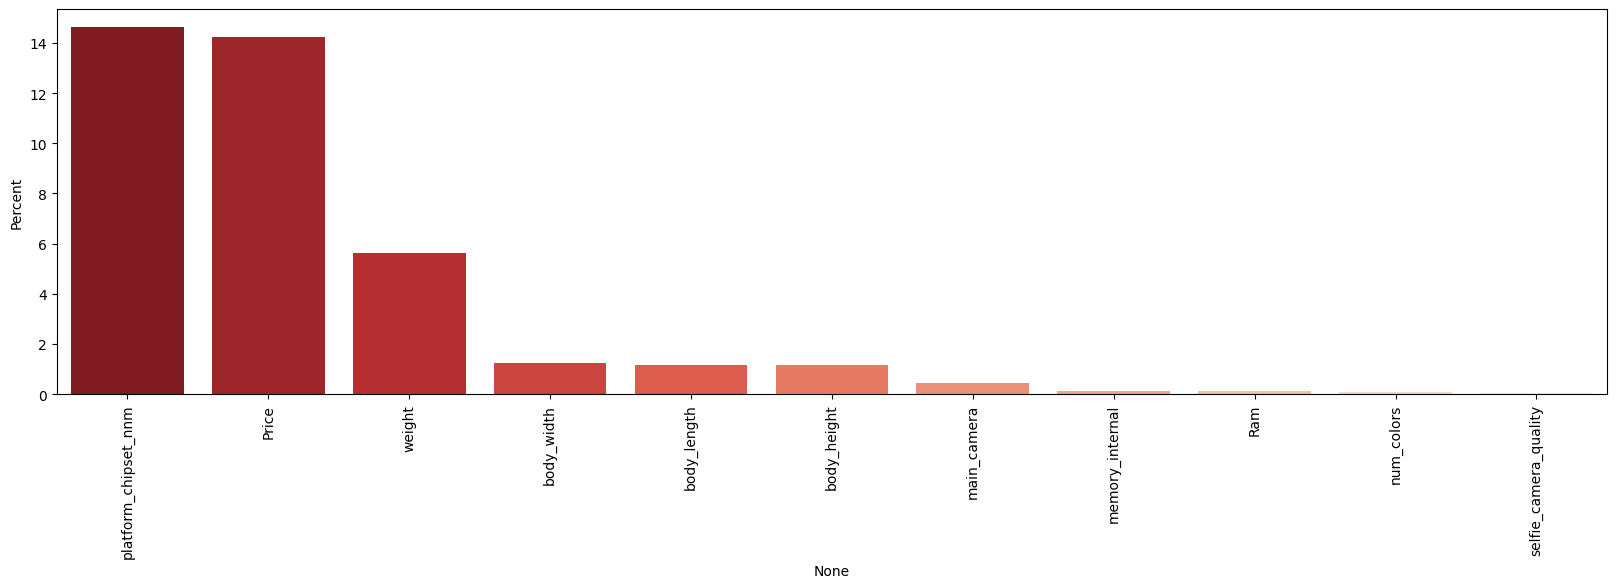

In [ ]:
def missing_percentage(df):

    """Hàm trả về phần trăm lượng  dữ liệu bị mất"""

    total = df.isnull().sum().sort_values(
        ascending=False)[df.isnull().sum().sort_values(ascending=False) != 0]
    percent = (df.isnull().sum().sort_values(ascending=False) / len(df) *
               100)[(df.isnull().sum().sort_values(ascending=False) / len(df) *
                     100) != 0]
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

missing = missing_percentage(avai_df)

fig, ax = plt.subplots(figsize=(20, 5))
sns.barplot(x=missing.index, y='Percent', data=missing, palette='Reds_r')
plt.xticks(rotation=90)

- Dựa vào biểu đồ phân tích trên, có thể thấy dữ liệu hai cột price và flatform_chipset_nnm có lượng dữ liệu missing lớn nhất trong các cột

In [ ]:
fill_na_cols = ['main_camera', 'weight', 'memory_internal', 'Ram', 'selfie_camera_quality','body_height','body_length','body_width']

for i in fill_na_cols:
    avai_df[i] = avai_df[i].fillna(avai_df[i].median())
avai_df.dropna(inplace = True)
avai_df.reset_index(drop=True, inplace=True)

In [ ]:
avai_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1936 entries, 0 to 1935
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Model                   1936 non-null   object 
 1   Brand                   1936 non-null   object 
 2   Released                1936 non-null   int64  
 3   body_length             1936 non-null   float64
 4   body_width              1936 non-null   float64
 5   body_height             1936 non-null   float64
 6   pixel_on_height         1936 non-null   int64  
 7   pixel_on_width          1936 non-null   int64  
 8   display_type            1936 non-null   object 
 9   refresh_rate            1936 non-null   int64  
 10  display_size            1936 non-null   float64
 11  platform_chipset_brand  1936 non-null   object 
 12  platform_chipset_nnm    1936 non-null   float64
 13  selfie_camera_quality   1936 non-null   float64
 14  charging_wired          1936 non-null   

- Thông qua quá trình làm sạch dữ liệu, bộ dữ liệu mới bao gồm 27 cột và chứa 2306 hàng.Tóm tắt một số các thuộc tính chính như sau:

1.   Model: tên của model điện thoại (str)
2.   Brand: tên của hãng điện thoại (str)
3.   Released: năm mà sản phẩm được phát hành (int)
4.   body_length: chiều dài của điện thoại (mm)
5.   body_width: chiều rộng của điện thoại (mm)
6.   body_height: chiều dày của điện thoại (mm)
7.   pixel_on_heigh: chiều cao của một pixel trên màn hình (pixel)
8.   pixel_on_width: chiều rộng của một pixel trên màn hình (pixel)
9.   refresh_rate: tần số quét của màn hình (hz)
10.  display_type: loại màn hình được sử dụng trong điện thoại
11.  platform_chipset_brand: hãng chip mà điện thoại sử dụng
12.  platform_chipset_nnm: tiến trình của chip sử dụng (nm)
13.  selfie_camera_quality: chất lượng của camera phía trước (MB)
14.  charging_wired: công suất sạc tối đa nếu có dây (w)
15.  charging_wireless: công suất sạc không dây (w)
16.  battery_capacity: dung lượng pin (mmAh)
17.  bluetooth_version: phiên bản bluetooth (int)
18.  fingerprint: điện thoại có hỗ trợ dấu vân tay hay không ?
19.  num_color: số lượng màu của điện thoại (int)
20.  have_3.5_jack: có jack 3.5 hay không?
21.  weight: trọng lượng của điện thoại (g)
22.  ram: dung lượng ram của điện thoại (GB)
23.  memory_internal: bộ nhớ trong (GB)
24.  Price: giá của điện thoại ($)
25.  main_camera: số lượng camera của điện thoại (int)


# 4. Chuẩn bị các tập dữ liệu train, test

In [ ]:
main_df = avai_df.copy()

In [ ]:
brand_counts = main_df['Brand'].value_counts()
rare_brands = brand_counts[brand_counts == 1]
main_df = main_df[main_df['Brand'] != rare_brands.index[0]]

In [ ]:
from sklearn.model_selection import train_test_split
main_df = main_df.drop(['Model', 'display_type'], axis = 1)
X = main_df.drop(['Price'], axis = 1)
# sử dụng log transformation
# y = np.log(main_df['Price'])
y = main_df['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=X['Brand'])

# 5. Phân tích dữ liệu
- Trong phần này, mục tiêu chính là phân tích và trực quan hóa dữ liệu trên, đồng thời lựa chọn các feature cho việc huấn luyện mô hình
- Đầu tiên, ta có bảng thông kê mô tả các cột của tập dữ liệu trên:

In [ ]:
main_df = X_train.copy()
main_df['Price'] = y_train
main_df.describe()

,Released,body_length,body_width,body_height,pixel_on_height,pixel_on_width,refresh_rate,display_size,platform_chipset_nnm,selfie_camera_quality,charging_wired,charging_wireless,battery_capacity,bluetooth_version,num_colors,weight,Ram,memory_internal,main_camera,Price
count,1548.000000,1548.000000,1548.000000,1548.000000,1548.000000,1548.000000,1548.000000,1548.000000,1548.000000,1548.000000,1548.000000,1548.000000,1548.000000,1548.000000,1548.000000,1548.000000,1548.000000,1548.000000,1548.000000,1548.000000
mean,2021.163437,162.075065,76.044703,8.840633,1000.510336,2181.465116,85.866279,6.499574,8.722222,15.138760,33.563953,3.412791,4722.614341,5.011757,2.757752,197.180426,6.156331,127.706718,2.790698,346.677962
std,1.429591,6.533299,6.859774,1.858104,231.103277,477.555993,29.615695,0.360784,4.200729,10.962463,31.661006,11.196177,1234.446974,0.283876,1.124493,36.278191,2.941815,92.513948,0.837928,295.781725
min,2019.000000,47.100000,35.000000,0.000000,192.000000,854.000000,60.000000,3.500000,3.000000,0.000000,5.000000,0.000000,420.000000,4.000000,1.000000,98.000000,1.000000,8.000000,1.000000,43.280000
25%,2020.000000,159.800000,74.400000,8.000000,720.000000,1600.000000,60.000000,6.430000,6.000000,8.000000,10.000000,0.000000,4200.000000,5.000000,2.000000,182.000000,4.000000,64.000000,2.000000,162.300000
50%,2021.000000,163.300000,75.600000,8.500000,1080.000000,2400.000000,60.000000,6.560000,7.000000,13.000000,20.000000,0.000000,4800.000000,5.000000,3.000000,190.500000,6.000000,128.000000,3.000000,259.680000
75%,2022.000000,164.700000,76.500000,9.000000,1080.000000,2400.000000,120.000000,6.670000,12.000000,16.000000,44.000000,0.000000,5000.000000,5.200000,3.000000,202.000000,8.000000,128.000000,3.000000,432.800000
max,2024.000000,183.700000,146.200000,27.200000,2268.000000,3840.000000,165.000000,7.920000,28.000000,60.000000,240.000000,100.000000,22000.000000,5.400000,11.000000,609.000000,24.000000,1000.000000,4.000000,3181.080000


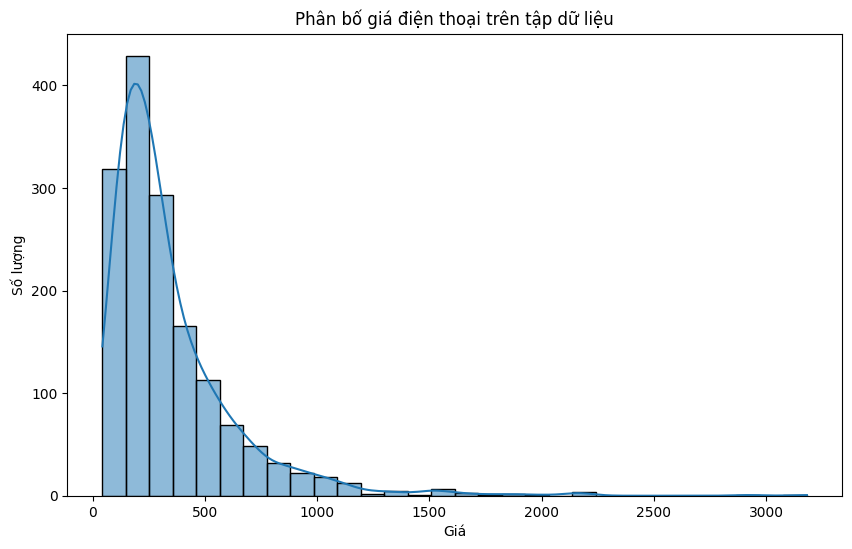

In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(main_df['Price'], bins=30, kde=True)
plt.xlabel('Giá')
plt.ylabel('Số lượng')
plt.title('Phân bố giá điện thoại trên tập dữ liệu')

plt.show()

- Từ biểu đồ trên, có thể thấy, trong tập dữ liệu phần lớn điện thoại đều nằm trong khoảng giá từ 0 đến 500. Từ đó có thể thấy, tập dữ liệu đang mất cân bằng về phía mức giá trên. Do đó, sử dụng log transform để chuẩn hóa lại dữ liệu về dạng phân bổ chuẩn

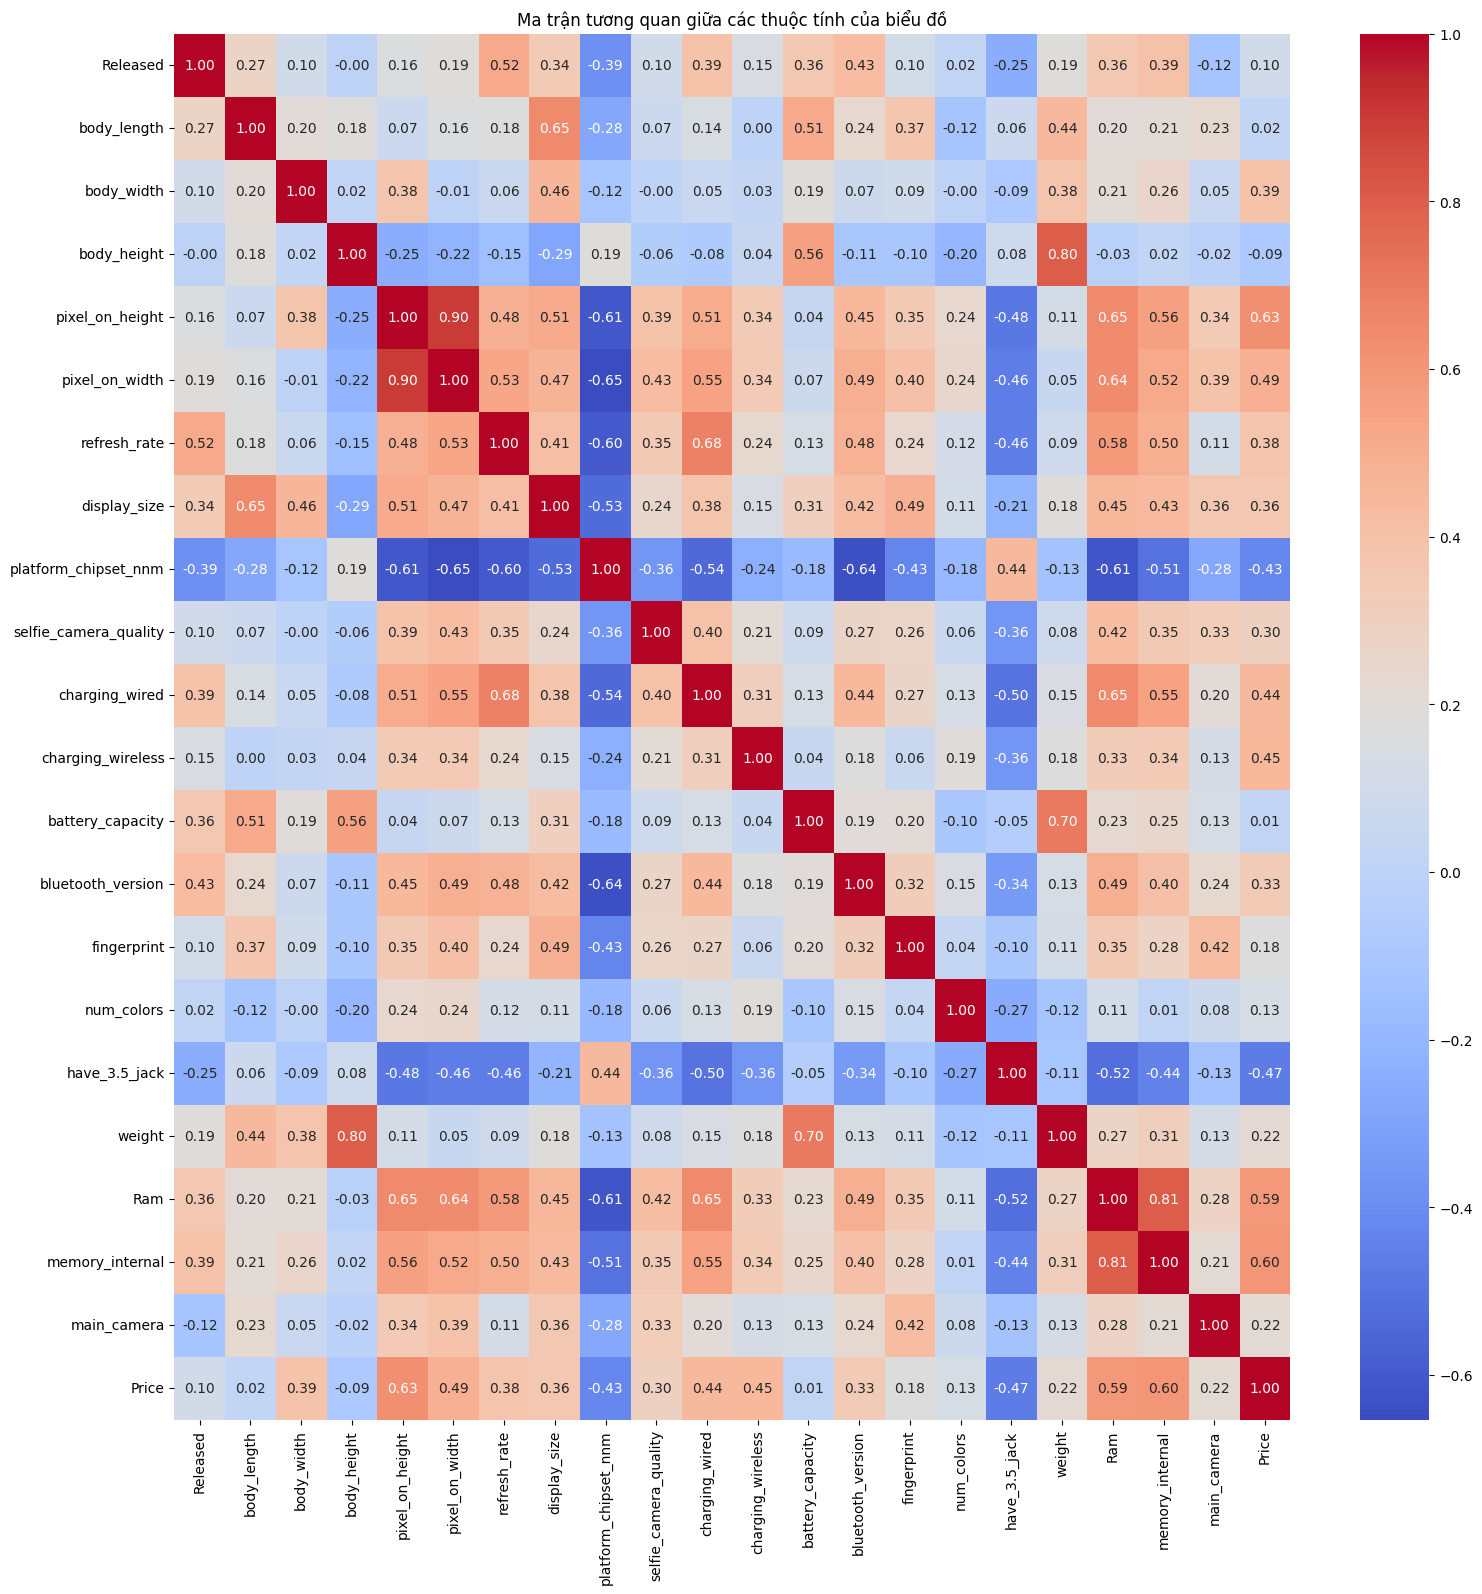

In [ ]:
plt.figure(figsize=(18, 18))
corr_matrix = main_df.corr(numeric_only = True)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")

plt.title('Ma trận tương quan giữa các thuộc tính của biểu đồ')
plt.show()

- Dựa vào ma trận tương quan trên, có thế thấy, giá có độ tương quan cao với các cột (pixel_on_height, pixel_on_width, refresh_rate, platform_chipset_nnm, selfie_camera_quality, charging_wired, charging_wireless, ram, memory_internal)
- Có thể thấy, giá càng lớn khi mật độ điểm ảnh của màn hình lớn, tần số quét cao, tốc đọ sạc nhanh, dung lượng lưu trữ lớn và kích thước bóng bán dẫn trong chip càng nhỏ.
- Ngoài việc xem xét độ tương quan giữa giá, có thể thấy một số cột có độ tương quan khá lớn so với nhau. Đầu tiên nếu xem xét cột platform_chipset_nnm, có thể thấy cột này có độ tương quan rất thấp so với các cột khác đặc biệt với các cột có độ tương quan cao với giá. Nếu nhìn vào một số cặp cột như (Ram, memory_internal), (body_height, weight), (pixel__height, pixel_on_width). Ta sẽ thực hiện phân tích tương quan giữa chúng và mức giá dưới đây

- Có thể thấy, hai cột dữ liệu pixel_on_height và pixel_on_width đều có độ tương quan lớn với price_level và chúng cũng có độ tương quan lớn với nhau.

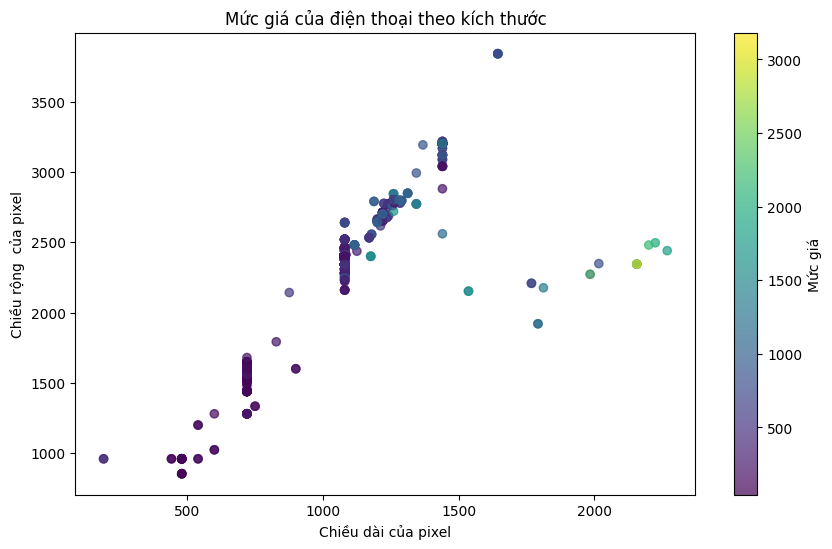

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(main_df['pixel_on_height'],  main_df['pixel_on_width'], c=main_df['Price'], cmap='viridis', alpha=0.7)
plt.xlabel('Chiều dài của pixel')
plt.ylabel('Chiều rộng  của pixel')
plt.title('Mức giá của điện thoại theo kích thước')
plt.colorbar(label='Mức giá')
plt.show()

- Dựa vào biểu đồ trên, ta thấy mức giá của điện thoại đều tăng khi chiều dài và chiều rộng tăng, do đó, ta có thể loại bỏ chiều rộng của pixel trong feature cho việc huấn luyện
- Ngoài ra, ma trận trên phân tích mỗi tương quan giữa các giá trị số của dữ liệu, tiếp theo, ta sẽ xem xét 2 cột platform_chip_brand và brand:

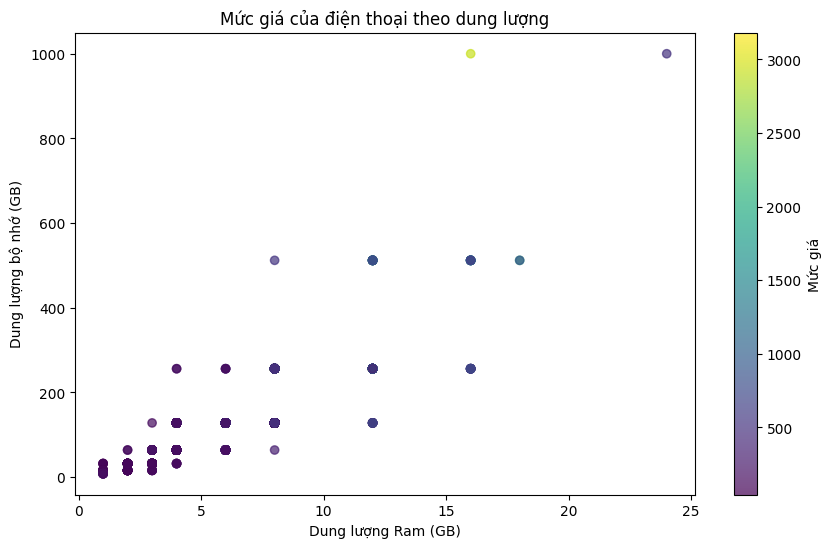

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(main_df['Ram'],  main_df['memory_internal'], c=main_df['Price'], cmap='viridis', alpha=0.7)
plt.xlabel('Dung lượng Ram (GB)')
plt.ylabel('Dung lượng bộ nhớ (GB)')
plt.title('Mức giá của điện thoại theo dung lượng')
plt.colorbar(label='Mức giá')
plt.show()

- Ta có thể thấy rõ, dữ liệu cột Ram và memory_internal cũng đang biểu diễn tỉ lệ thuận với nhau theo giá, từ đó ta cũng có thể loại bỏ một trong hai cột ra khỏi dữ liệu huấn luyện. Điều này xảy ra tương tự đối với 2 cột body_height và weight.

Tương tự như trên, Ram và memory_internal cũng có độ tương quan cao, do đó ta lựa chọn memory_internal là một thuộc tính

### Phân tích dữ liệu category
- Tại đây, nhóm phân tích dữ liệu category trong tập dữ liệu với mục tiêu chuyển đổi chúng trở về dạng số. Thay vì sử dụng one-hot encoding (có quá nhiều trường dữ liệu) nhóm quyết định chuyển đổi các category sang dạng số
- Các thức chuyển đổi là sử dụng phân bố của từng category theo giá, từ đó xác định giá trị median của phân bố đó. Giá trị này sẽ được sử dụng làm giá trị dạng số thay vì tên của brand. Nó sẽ phản ánh một phần giá trị của brand tác động lên giá nhưng không là một phép chuyển đổi hoàn toàn của giá do phân bố có nhiều ngoại lệ

<ipython-input-37-2d36873a3668>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='platform_chipset_brand', y='Price', data=main_df, order=sorted_brands, palette='plasma')


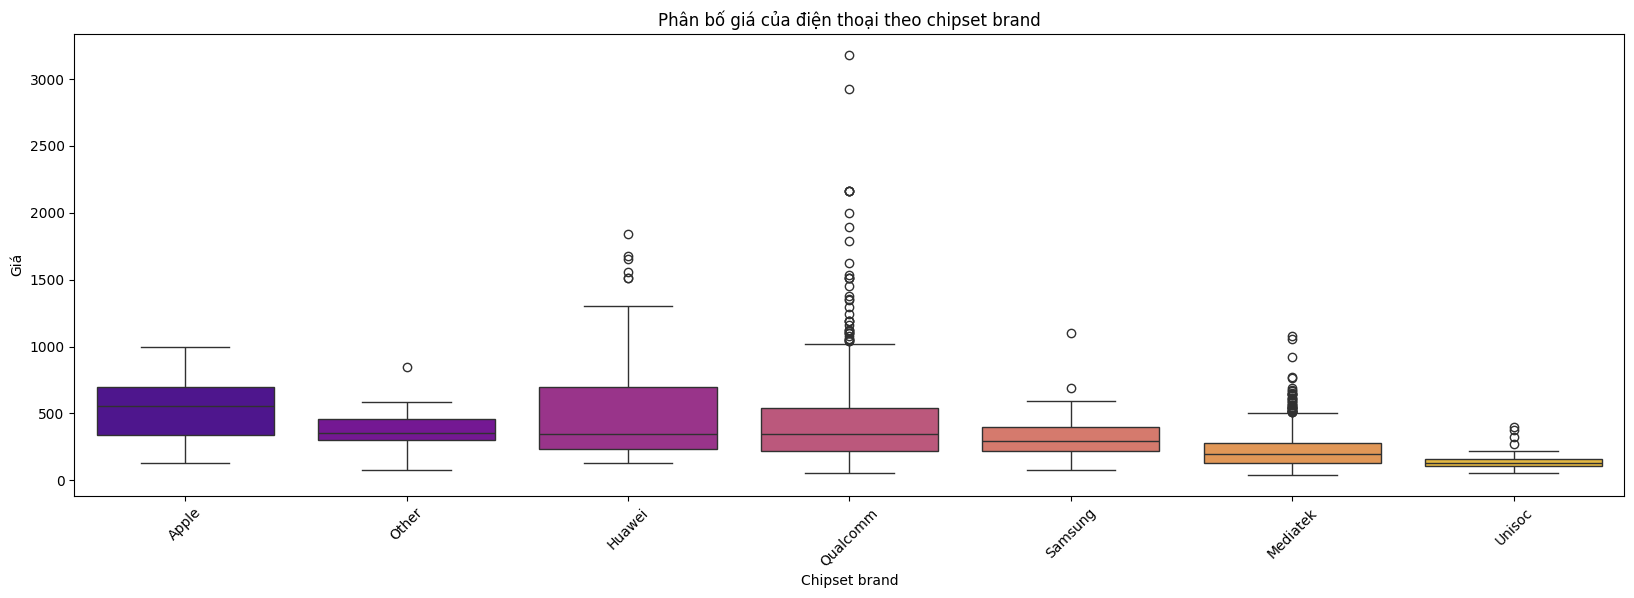

In [ ]:
sorted_brands = main_df.groupby('platform_chipset_brand')['Price'].median().sort_values(ascending=False).index

# Plotting the boxplot with the sorted brand order using seaborn
plt.figure(figsize=(20, 6))
sns.boxplot(x='platform_chipset_brand', y='Price', data=main_df, order=sorted_brands, palette='plasma')

# Adjust plot aesthetics
plt.title("Phân bố giá của điện thoại theo chipset brand")
plt.ylabel("Giá")
plt.xlabel("Chipset brand")
plt.xticks(rotation=45)
plt.show()

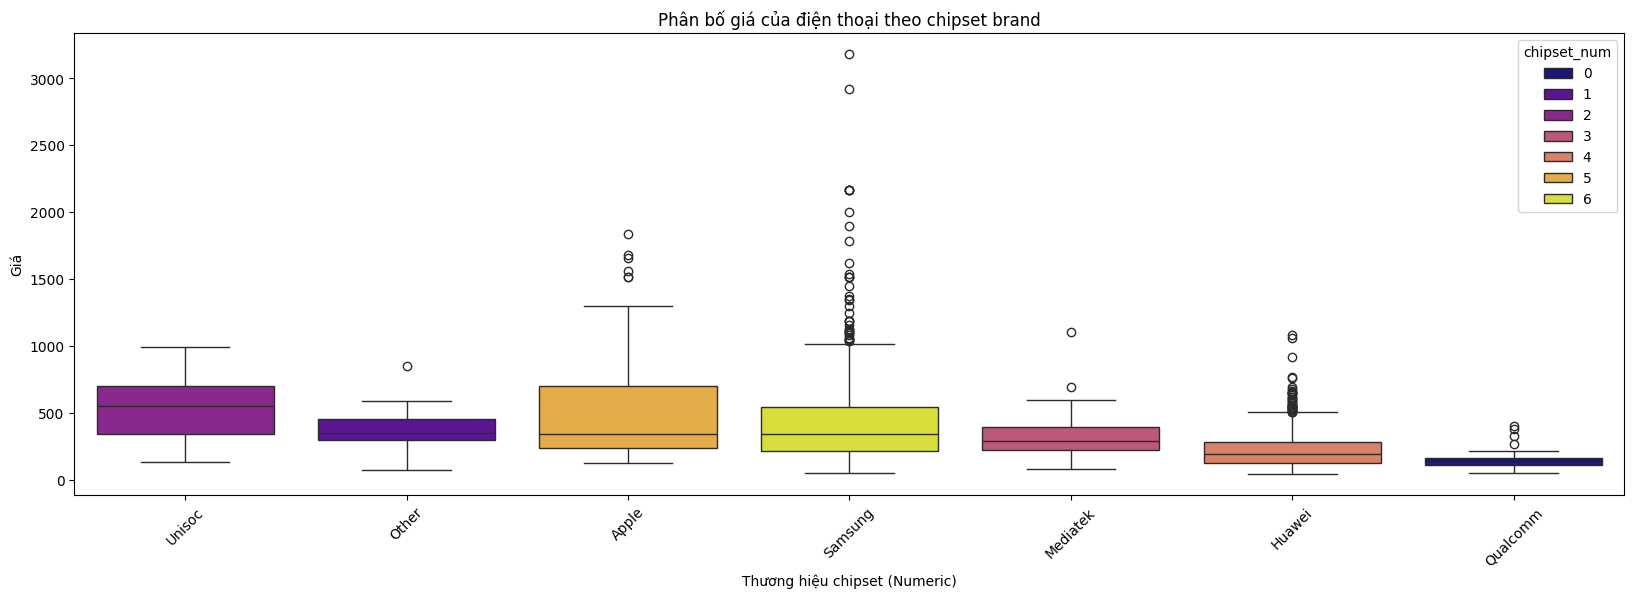

In [ ]:
brand_ranges = main_df.groupby('platform_chipset_brand')['Price'].agg(lambda x: x.max() - x.min()).sort_values()

# Map brands to numeric values based on their sorted range order
chipset_to_numeric = {brand: num for num, brand in enumerate(brand_ranges.index)}

# Create a new column in the DataFrame with the numeric values
main_df['chipset_num'] = main_df['platform_chipset_brand'].map(chipset_to_numeric)
main_df = main_df.drop('platform_chipset_brand', axis=1)
# Plotting the boxplot with the numeric brand order using seaborn
plt.figure(figsize=(20, 6))
sorted_brandnum = main_df.groupby('chipset_num')['Price'].median().sort_values(ascending=False).index
sns.boxplot(x='chipset_num', y='Price', data=main_df, order=sorted_brandnum, hue='chipset_num', palette='plasma')

# Adjust plot aesthetics
plt.title("Phân bố giá của điện thoại theo chipset brand")
plt.ylabel("Giá")
plt.xlabel("Thương hiệu chipset (Numeric)")
plt.xticks(ticks=range(len(chipset_to_numeric)), labels=brand_ranges.index, rotation=45)
plt.show()

- Dựa vào biểu đồ trên, có thể thấy Mediatek, Qualcomm có số lượng outlier lớn. Mediatek là thương hiệu chipset cho điện thoại giá rẻ tuy nhiên lại có lượng outlier lớn, do đó nếu lựa chọn thuộc tính này vào phân tích có thể tạo ra nhiễu cho mô hình

<ipython-input-39-c380b14c299d>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Brand', y='Price', data=main_df, order=sorted_brands, palette='plasma')


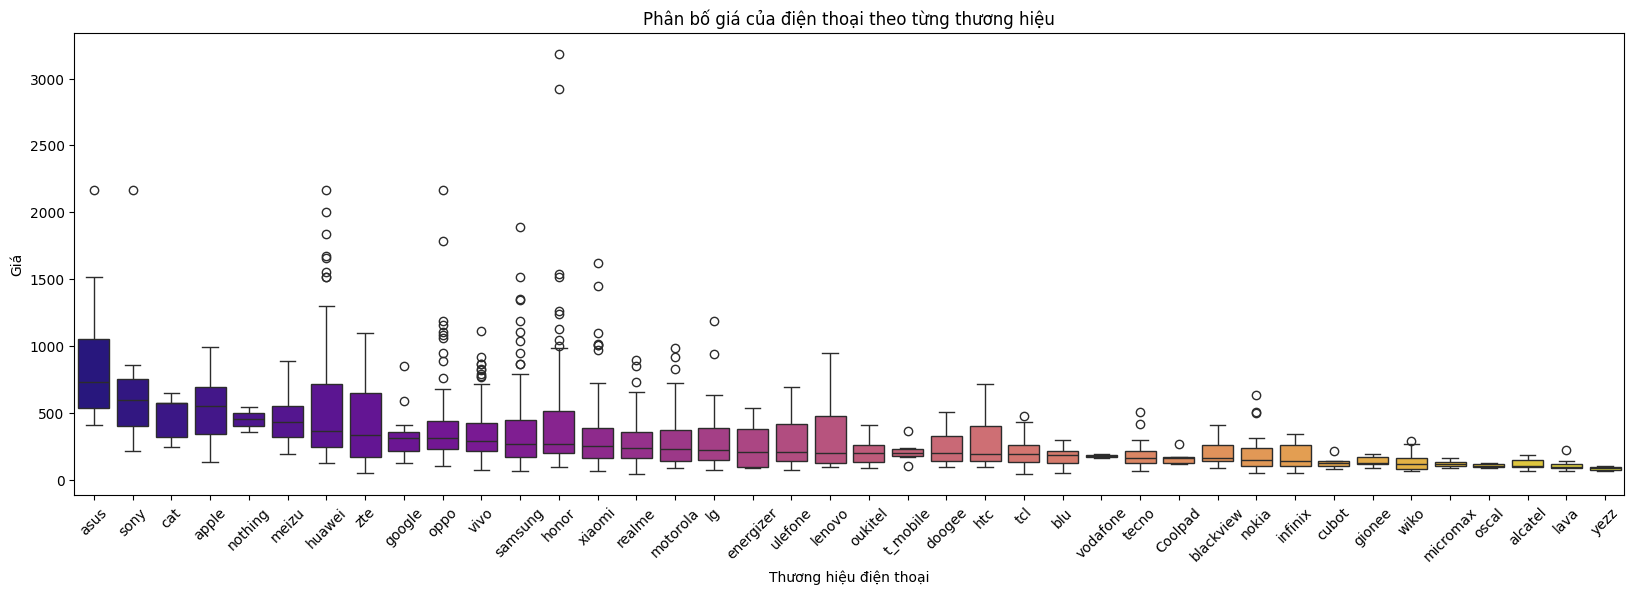

In [ ]:
sorted_brands = main_df.groupby('Brand')['Price'].median().sort_values(ascending=False).index

# Plotting the boxplot with the sorted brand order using seaborn
plt.figure(figsize=(20, 6))
sns.boxplot(x='Brand', y='Price', data=main_df, order=sorted_brands, palette='plasma')

# Adjust plot aesthetics
plt.title("Phân bố giá của điện thoại theo từng thương hiệu")
plt.ylabel("Giá")
plt.xlabel("Thương hiệu điện thoại")
plt.xticks(rotation=45)
plt.show()

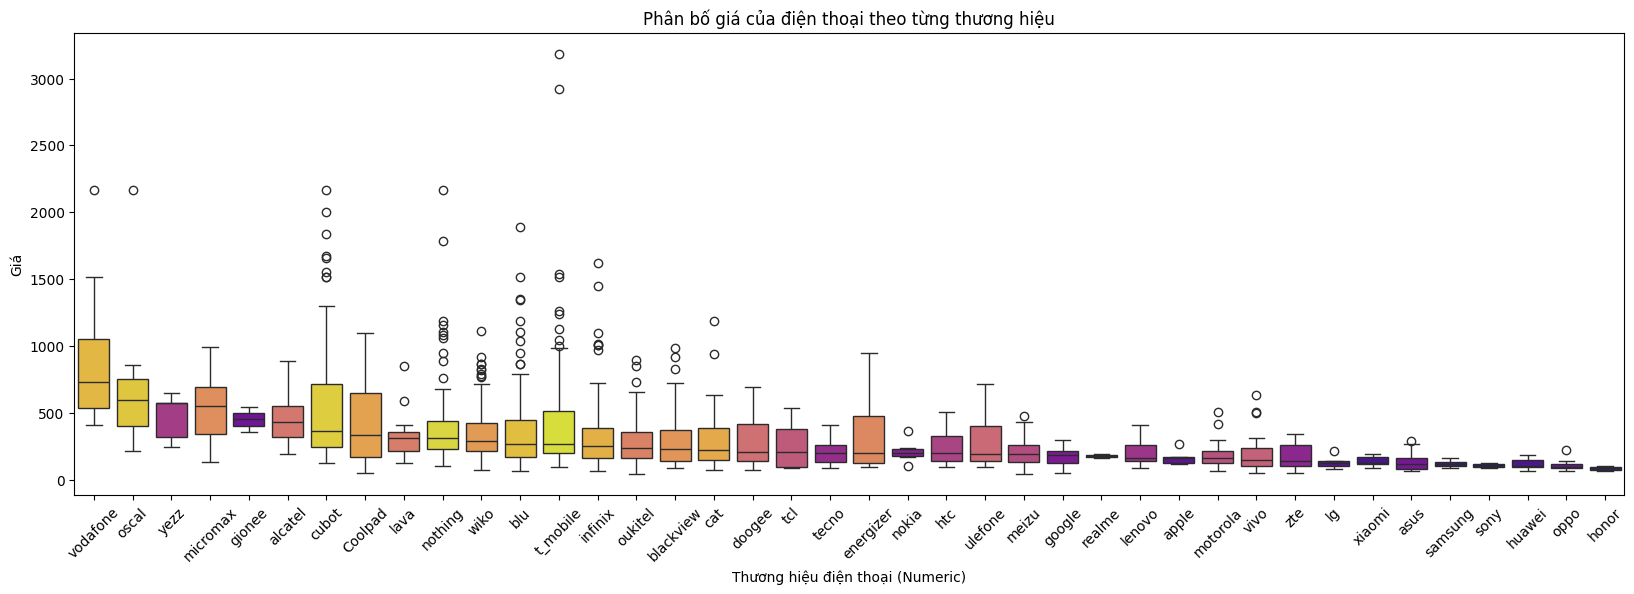

In [ ]:
brand_ranges = main_df.groupby('Brand')['Price'].agg(lambda x: x.max() - x.min()).sort_values()

# Map brands to numeric values based on their sorted range order
brand_to_numeric = {brand: num for num, brand in enumerate(brand_ranges.index)}

# Create a new column in the DataFrame with the numeric values
main_df['BrandNumeric'] = main_df['Brand'].map(brand_to_numeric)
main_df = main_df.drop('Brand', axis=1)
# Plotting the boxplot with the numeric brand order using seaborn
plt.figure(figsize=(20, 6))
sorted_brandnum = main_df.groupby('BrandNumeric')['Price'].median().sort_values(ascending=False).index
sns.boxplot(x='BrandNumeric', y='Price', data=main_df,order=sorted_brandnum, palette='plasma', dodge=False, hue ='BrandNumeric')

# Adjust plot aesthetics
plt.title("Phân bố giá của điện thoại theo từng thương hiệu")
plt.ylabel("Giá")
plt.xlabel("Thương hiệu điện thoại (Numeric)")
plt.xticks(ticks=range(len(brand_to_numeric)), labels=brand_ranges.index, rotation=45)
plt.legend([],[], frameon=False)
plt.show()

- Tương tự như trên, phân bố của dữ liệu phân loại theo từng thương hiệu cũng có lượng outlier khá lớn.

In [ ]:
X_train = main_df.drop(['Price'], axis = 1)
y_train = main_df['Price']

In [ ]:
# brand to ordinal
X_test['BrandNumeric'] = X_test['Brand'].map(brand_to_numeric)
X_test = X_test.drop('Brand', axis=1)

# X_train['BrandNumeric'] = X_train['Brand'].map(brand_to_numeric)
# X_train = X_train.drop('Brand', axis=1)

# chipset to numeric
X_test['chipset_num'] = X_test['platform_chipset_brand'].map(chipset_to_numeric)
X_test = X_test.drop('platform_chipset_brand', axis=1)

# X_train['chipset_num'] = X_train['platform_chipset_brand'].map(chipset_to_numeric)
# X_train = X_train.drop('platform_chipset_brand', axis=1)

### Phân tích dữ liệu numerical
- Trong phần này, nhóm phân tích các trường dữ liệu số với mục tiêu là loại bỏ các ngoại lệ ra khỏi tập dữ liệu
- Sử dụng các đường hồi quy để xác định xu hướng của dữ liệu theo giá, từ đó xác định luật để loại bỏ các điểm ngoại lệ ra khỏi tập dữ liệu

In [ ]:
from matplotlib.ticker import MaxNLocator
num_cols = main_df.columns
def srt_reg(y, df):
    fig, axes = plt.subplots(8, 3, figsize=(25, 80))
    axes = axes.flatten()

    for i, j in zip(df.columns, axes):

        sns.regplot(x=i,
                    y=y,
                    data=df,
                    ax=j,
                    order=3,
                    ci=None,
                    color='#e74c3c',
                    line_kws={'color': 'black'},
                    scatter_kws={'alpha':0.4})
        j.tick_params(labelrotation=45)
        j.yaxis.set_major_locator(MaxNLocator(nbins=10))

        plt.tight_layout()

/usr/local/lib/python3.10/dist-packages/seaborn/regression.py:261: RankWarning: Polyfit may be poorly conditioned
  return np.polyval(np.polyfit(_x, _y, order), grid)
/usr/local/lib/python3.10/dist-packages/seaborn/regression.py:261: RankWarning: Polyfit may be poorly conditioned
  return np.polyval(np.polyfit(_x, _y, order), grid)


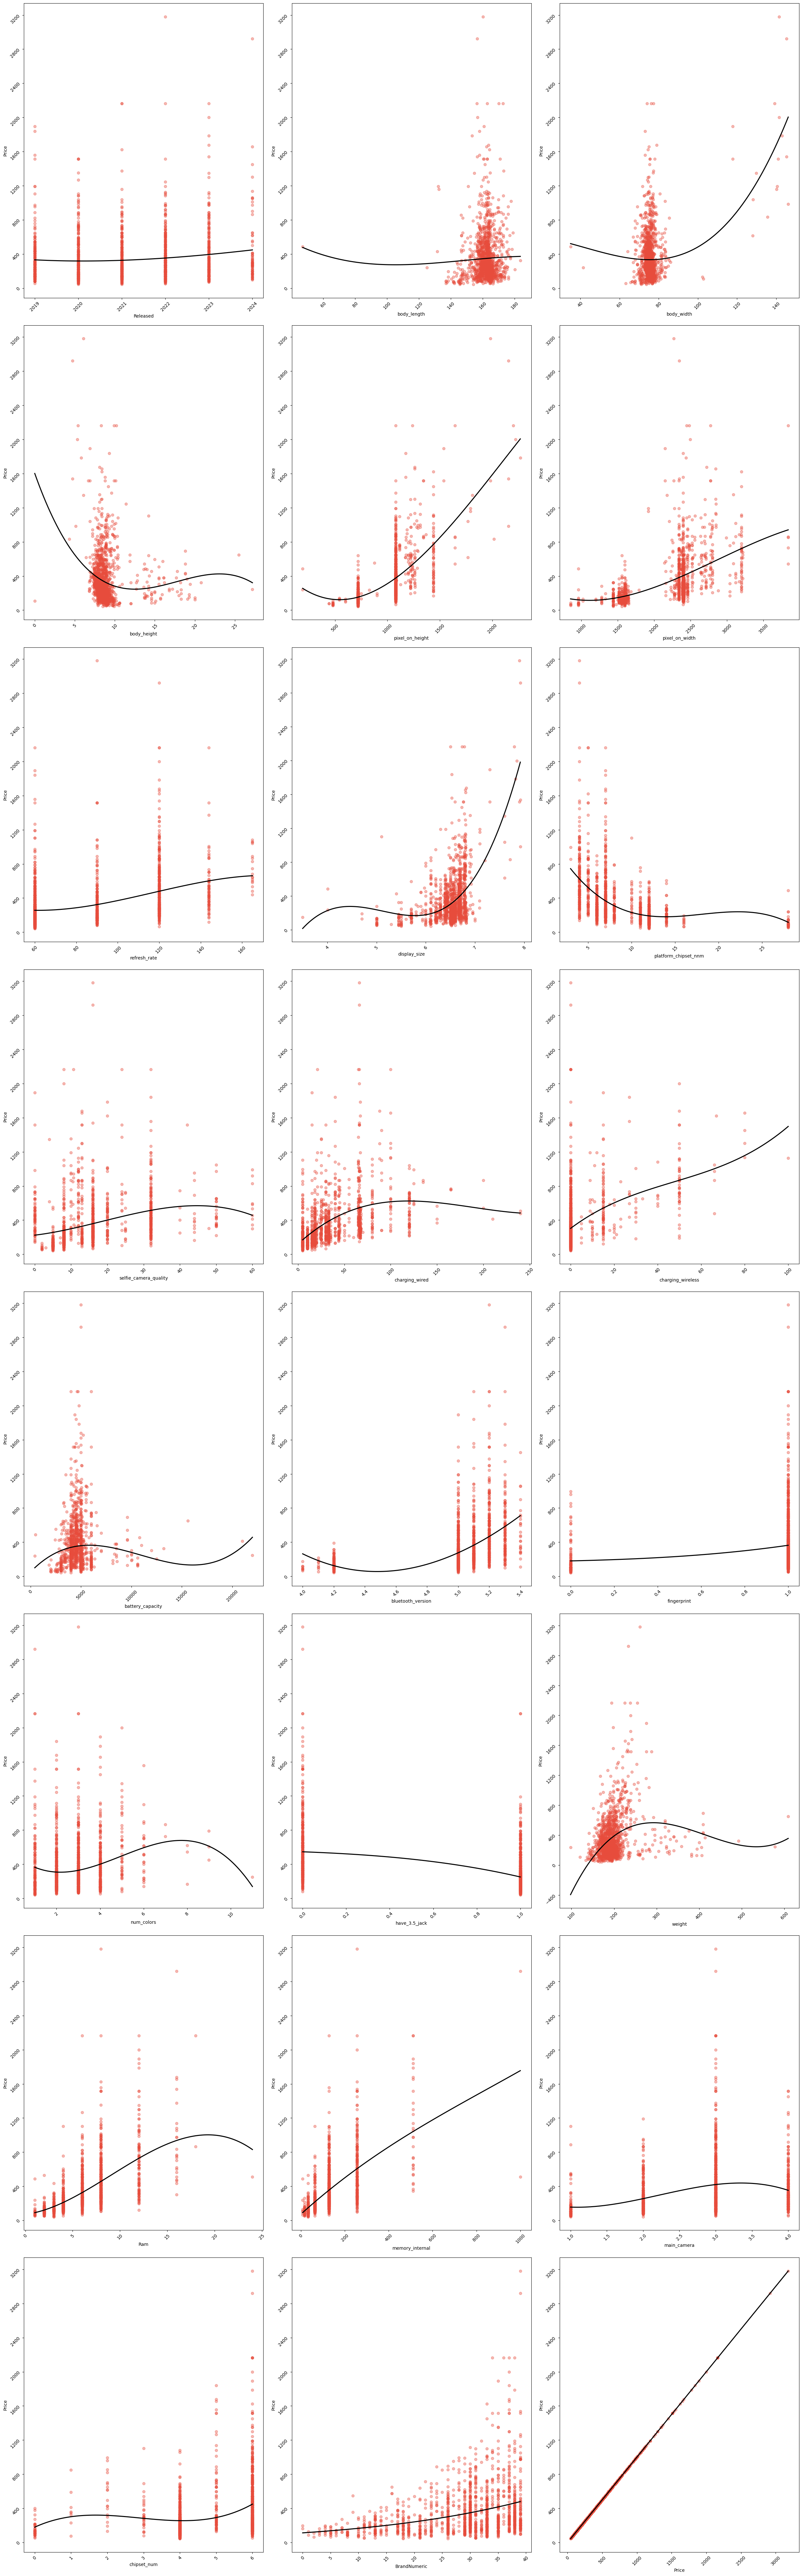

In [ ]:
srt_reg("Price",main_df[['Released', 'body_length', 'body_width', 'body_height', 'pixel_on_height', 'pixel_on_width',
'refresh_rate', 'display_size', 'platform_chipset_nnm', 'selfie_camera_quality','charging_wired', 'charging_wireless', 'battery_capacity', 'bluetooth_version',
                         'fingerprint','num_colors', 'have_3.5_jack', 'weight', 'Ram',
                         'memory_internal', 'main_camera', 'chipset_num', 'BrandNumeric', 'Price']])

In [ ]:
main_df.drop(main_df[main_df['Price'] > 2400].index, inplace=True)

In [ ]:
ram_drop = main_df[main_df['Ram'] > 20]
body_length_drop1 = main_df[(main_df['body_length'] > 200) & (main_df['Price'] < 700)]
body_length_drop2 = main_df[(main_df['body_length'] < 135) & (main_df['Price'] > 1000)]
body_width_drop = main_df[(main_df['body_width'] > 100) & (main_df['Price'] < 250)]
body_height_drop1 = main_df[(main_df['body_height'] > 13) & (main_df['Price'] > 1000)]
body_height_drop2 = main_df[(main_df['body_height'] > 25) & (main_df['Price'] > 500)]
ph_drop = main_df[(main_df['pixel_on_height'] > 2000) & (main_df['Price'] > 1900)]
pw_drop = main_df[(main_df['pixel_on_width'] > 3500) & (main_df['Price'] > 2000)]
cw_drop = main_df[(main_df['charging_wireless'] > 90) & (main_df['Price'] < 1200)]
bc_drop = main_df[(main_df['battery_capacity'] > 15000) & (main_df['Price'] > 500)]
weight_drop = main_df[(main_df['weight'] > 550) & (main_df['Price'] > 600)]

In [ ]:
all_drops = pd.concat([ram_drop, body_length_drop1, body_length_drop2, body_width_drop,
                       body_height_drop1, body_height_drop2, ph_drop, pw_drop,
                       cw_drop, bc_drop, weight_drop])

main_df.drop(all_drops.index)

,Released,body_length,body_width,body_height,pixel_on_height,pixel_on_width,refresh_rate,display_size,platform_chipset_nnm,selfie_camera_quality,...,fingerprint,num_colors,have_3.5_jack,weight,Ram,memory_internal,main_camera,Price,chipset_num,BrandNumeric
751,2023,162.9,74.0,8.3,1240,2772,120,6.74,4.0,32.0,...,True,3.0,False,194.0,6.0,128.0,3.0,2164.00000,6,38
1618,2021,162.5,74.8,8.5,1080,2400,90,6.50,7.0,16.0,...,True,2.0,True,185.0,4.0,64.0,3.0,119.02000,4,26
815,2021,163.8,75.6,8.4,720,1600,60,6.52,12.0,8.0,...,True,3.0,True,190.0,4.0,128.0,3.0,199.99000,4,38
109,2022,167.4,81.4,14.6,720,1440,60,6.00,12.0,8.0,...,True,4.0,True,266.0,6.0,64.0,2.0,183.94000,4,17
26,2022,173.0,77.0,10.3,1080,2448,165,6.78,4.0,12.0,...,True,2.0,True,239.0,8.0,128.0,3.0,481.14376,6,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342,2021,159.1,74.1,9.0,720,1600,60,6.30,14.0,8.0,...,True,3.0,True,185.0,4.0,64.0,2.0,140.66000,4,37
1394,2022,163.0,76.0,8.0,1080,2400,120,6.67,6.0,16.0,...,True,4.0,True,187.0,6.0,128.0,3.0,199.99000,4,33
493,2021,163.5,75.7,8.5,720,1600,90,6.51,11.0,13.0,...,True,1.0,True,200.0,4.0,64.0,4.0,162.30000,6,27
1266,2021,159.9,75.1,8.4,1080,2400,90,6.50,8.0,32.0,...,True,4.0,True,189.0,4.0,128.0,4.0,173.01180,6,35


### Phân bố dữ liệu

- Tiếp theo đó, ta thực hiện xem xét phân bố giá trị của các thuộc tính trong cột. Dựa vào biểu đồ phía dưới, có thể thấy, phân bố của dữ liệu đang bị chênh lệch  khoảng lớn, có thể ảnh hướng tới quá trình huấn luyện mô hình

<ipython-input-51-116cdf282056>:3: UserWarning: 
The palette list has fewer values (5) than needed (24) and will cycle, which may produce an uninterpretable plot.
  sns.boxenplot(data = main_df,palette = shades)


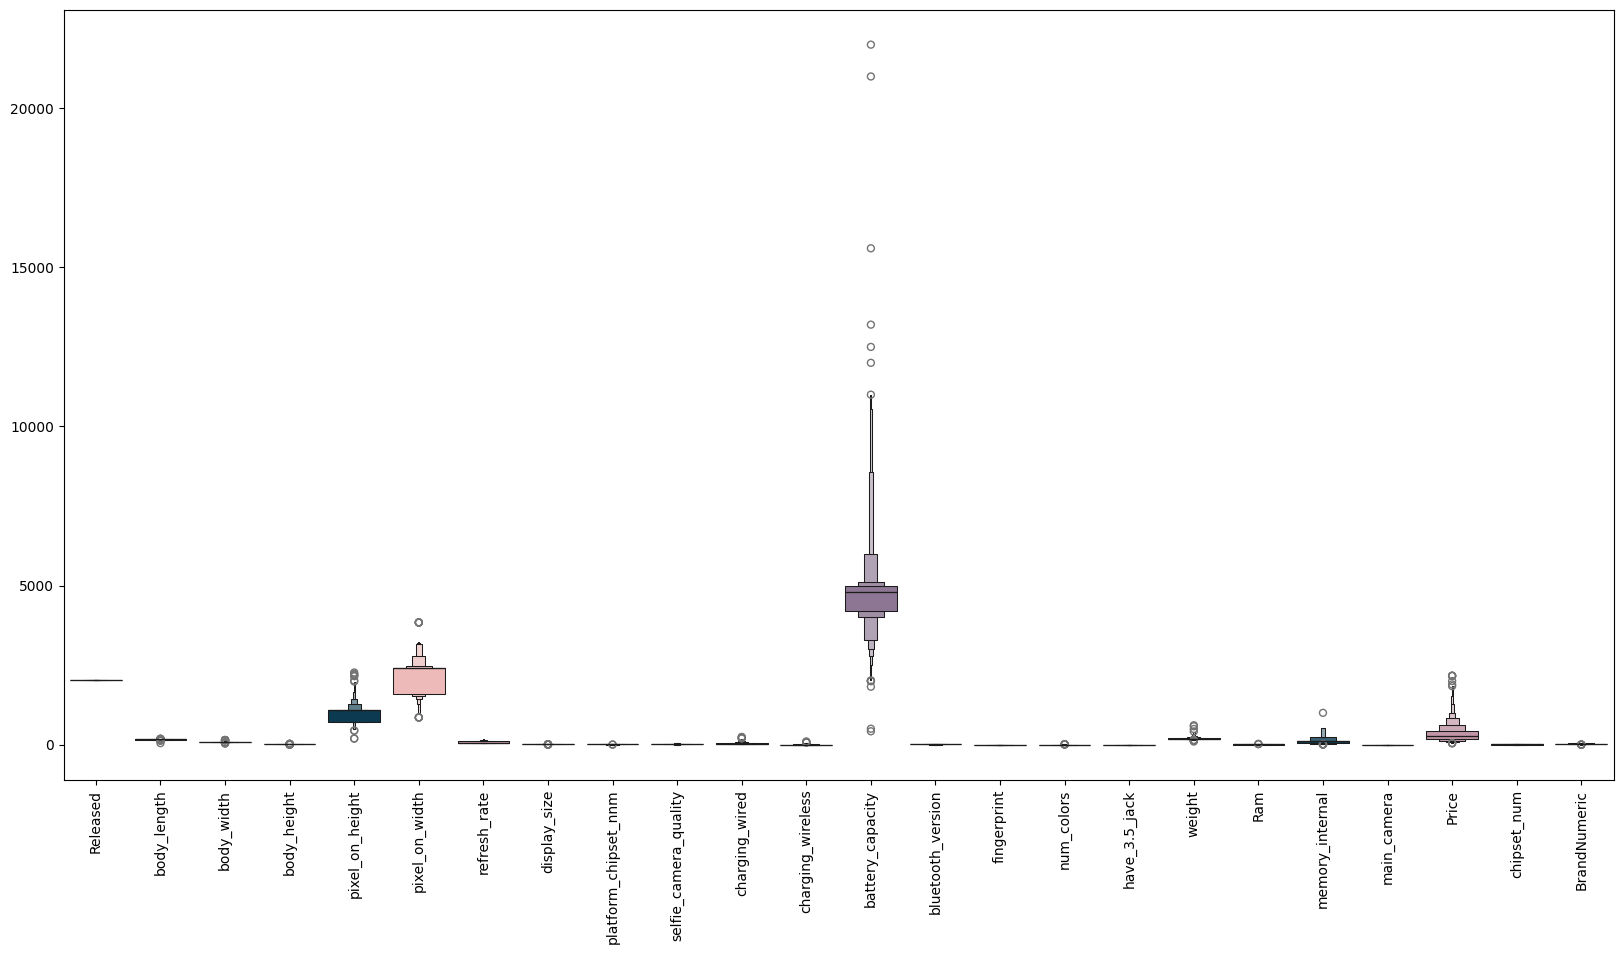

In [ ]:
shades =["#f7b2b0","#c98ea6","#8f7198","#50587f", "#003f5c"]
plt.figure(figsize=(20,10))
sns.boxenplot(data = main_df,palette = shades)
plt.xticks(rotation=90)
plt.show()

# 6. Lựa chọn mô hình

## Chuẩn hóa dữ liệu
- Trong phần này, nhóm sẽ thực hiện chuẩn hóa dữ liệu đưa dữ liệu từ nhiều khoảng khác nhau về cùng khoảng -1 đến 1 với StandardScaler

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

num_att = X.select_dtypes(exclude=['object']).columns.tolist()

# Xây dựng pipeline cho tiền xử lý dữ liệu
prepare_pipeline = ColumnTransformer([
    ('num', StandardScaler(), num_att)
])

In [ ]:
X_train_prep = prepare_pipeline.fit_transform(X_train)
X_test_prep = prepare_pipeline.fit_transform(X_test)

## Mô hình baseline
- Để xây dựng mô hình baseline, nhóm lựa chọn mô hình Linear Regression cho bài toán này. Mô hình Linear regression là mô hình miêu tả tập dữ liệu đơn giản theo một đường thẳng. Dựa vào ma trận tương quan, ta có thể thấy có nhiều trường dữ liệu ảnh hướng tới giá. Do đó nhóm lựa chọn đây là mô hình baseline

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

linear_reg_model = LinearRegression()
linear_reg_model.fit(X_train_prep, y_train)

linear_reg_scores = cross_val_score(linear_reg_model, X_train_prep, y_train, cv=10, scoring='neg_mean_squared_error')

y_pred = linear_reg_model.predict(X_test_prep)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Cross-Validation MSE Scores:\n{-linear_reg_scores}")
print(f"Mean Cross-Validation MSE Score: {-linear_reg_scores.mean()}")
print("Mean Squared Error on Test Set:", mse)
print("Root Mean Squared Error on Test Set:", rmse)
print("R² Score on Test Set:", r2)

Cross-Validation MSE Scores:
[38584.19330771 32255.27621042 25413.16896205 23516.96067943
 43498.73727899 43367.69138737 27451.2449797  31789.80335822
 70182.16015603 26439.48231671]
Mean Cross-Validation MSE Score: 36249.87186366354
Mean Squared Error on Test Set: 33648.8807071284
Root Mean Squared Error on Test Set: 183.43631240059423
R² Score on Test Set: 0.5965987088582185


## Thực nghiệm trên các mô hình học máy khác nhau

- Phần này, nhóm thử nghiệm nhiều loại mô hình trên tập dữ liệu và tính sai số mse của cross_validation. Sau đó sẽ lựa chọn mô hình có sai số thấp nhất và thực hiện fine tuning siêu tham số

### Rigde Regression

In [ ]:
from sklearn.linear_model import Ridge

ridge_model = Ridge()
ridge_model.fit(X_train_prep, y_train)

ridge_scores = cross_val_score(ridge_model, X_train_prep, y_train, cv=10, scoring='neg_mean_squared_error')

y_pred = ridge_model.predict(X_test_prep)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Cross-Validation MSE Scores:\n{-ridge_scores}")
print(f"Mean Cross-Validation MSE Score: {-ridge_scores.mean()}")
print("Mean Squared Error on Test Set:", mse)
print("Root Mean Squared Error on Test Set:", rmse)
print("R² Score on Test Set:", r2)

Cross-Validation MSE Scores:
[38639.44172909 32219.65308313 25397.92911305 23502.35382462
 42832.60003465 43605.32199495 27583.12047196 31350.07058927
 70507.07237995 26283.66464469]
Mean Cross-Validation MSE Score: 36192.12278653627
Mean Squared Error on Test Set: 33567.74784043823
Root Mean Squared Error on Test Set: 183.21503169892537
R² Score on Test Set: 0.5975713742928199


### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor

decision_tree_model = DecisionTreeRegressor(random_state=42)
decision_tree_model.fit(X_train_prep, y_train)

dt_scores = cross_val_score(decision_tree_model, X_train_prep, y_train, cv=10, scoring='neg_mean_squared_error')

y_pred = decision_tree_model.predict(X_test_prep)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Cross-Validation MSE Scores:\n{-dt_scores}")
print(f"Mean Cross-Validation MSE Score: {-dt_scores.mean()}")
print("Mean Squared Error on Test Set:", mse)
print("Root Mean Squared Error on Test Set:", rmse)
print("R² Score on Test Set:", r2)

Cross-Validation MSE Scores:
[68144.63182027 91587.45270915 42517.42152445 30437.24436625
 61545.41580903 74184.50836534 21455.78411618 31645.31230589
 87899.18644897 40817.93692498]
Mean Cross-Validation MSE Score: 55023.48943905214
Mean Squared Error on Test Set: 65888.41396559308
Root Mean Squared Error on Test Set: 256.6873856768055
R² Score on Test Set: 0.21009345017013725


### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

random_forest_model = RandomForestRegressor(random_state=42)
random_forest_model.fit(X_train_prep, y_train)

rf_scores = cross_val_score(random_forest_model, X_train_prep, y_train, cv=10, scoring='neg_mean_squared_error')

y_pred = random_forest_model.predict(X_test_prep)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Cross-Validation MSE Scores:\n{-rf_scores}")
print(f"Mean Cross-Validation MSE Score: {-rf_scores.mean()}")
print("Mean Squared Error on Test Set:", mse)
print("Root Mean Squared Error on Test Set:", rmse)
print("R² Score on Test Set:", r2)

Cross-Validation MSE Scores:
[36448.16433538 34555.45014748 15297.12519917 20504.22726889
 34973.29939442 40516.78293789 13694.87546572 18116.15148645
 65445.61543706 18145.77959627]
Mean Cross-Validation MSE Score: 29769.74712687237
Mean Squared Error on Test Set: 28887.83309466463
Root Mean Squared Error on Test Set: 169.96421121714016
R² Score on Test Set: 0.6536767665437602


- Dựa vào kết quả đánh giá 2 mô hình trên, hai mô hình đều có mean cross-val nhỏ hơn so với baseline và mô hình Random Forest có sai số tương đối nhỏ

### Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gradient_boosting_model = GradientBoostingRegressor(random_state=42)
gradient_boosting_model.fit(X_train_prep, y_train)

gb_scores = cross_val_score(gradient_boosting_model, X_train_prep, y_train, cv=10, scoring='neg_mean_squared_error')

y_pred = gradient_boosting_model.predict(X_test_prep)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Cross-Validation MSE Scores:\n{-gb_scores}")
print(f"Mean Cross-Validation MSE Score: {-gb_scores.mean()}")
print("Mean Squared Error on Test Set:", mse)
print("Root Mean Squared Error on Test Set:", rmse)
print("R² Score on Test Set:", r2)


Cross-Validation MSE Scores:
[31078.89712499 31227.64638075 16820.15789595 18224.2040769
 44411.36814753 42464.17496796 17637.06776912 21662.81939014
 67979.04244204 18498.68532576]
Mean Cross-Validation MSE Score: 31000.406352114216
Mean Squared Error on Test Set: 24283.2440310698
Root Mean Squared Error on Test Set: 155.83081861772337
R² Score on Test Set: 0.708879113082377


### SVM

In [ ]:
from sklearn.svm import SVR

svm_model = SVR(C=1.0, epsilon=0.2)
svm_model.fit(X_train_prep, y_train)

svm_scores = cross_val_score(svm_model, X_train_prep, y_train, cv=10, scoring='neg_mean_squared_error')

y_pred = svm_model.predict(X_test_prep)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Cross-Validation MSE Scores:\n{-svm_scores}")
print(f"Mean Cross-Validation MSE Score: {-svm_scores.mean()}")
print("Mean Squared Error on Test Set:", mse)
print("Root Mean Squared Error on Test Set:", rmse)
print("R² Score on Test Set:", r2)

Cross-Validation MSE Scores:
[ 60844.26356839  89780.3294589   56922.12329019  53388.00374236
  99560.28100673 136173.21507663  46124.70611674  46220.00713674
 171379.65987192  62531.85113866]
Mean Cross-Validation MSE Score: 82292.44404072735
Mean Squared Error on Test Set: 77598.39287680997
Root Mean Squared Error on Test Set: 278.5648809107314
R² Score on Test Set: 0.06970778167961877


### Stochastic Gradient Descent

In [ ]:
from sklearn.linear_model import SGDRegressor

sgd_model = SGDRegressor(random_state=42)
sgd_model.fit(X_train_prep, y_train)

sgd_scores = cross_val_score(sgd_model, X_train_prep, y_train, cv=10, scoring='neg_mean_squared_error')

y_pred = sgd_model.predict(X_test_prep)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Cross-Validation MSE Scores:\n{-sgd_scores}")
print(f"Mean Cross-Validation MSE Score: {-sgd_scores.mean()}")
print("Mean Squared Error on Test Set:", mse)
print("Root Mean Squared Error on Test Set:", rmse)
print("R² Score on Test Set:", r2)

Cross-Validation MSE Scores:
[41098.73709111 33082.5008939  24905.4313612  24460.39322062
 39869.5654269  44777.79136292 28299.7410769  29680.21553222
 74852.42557632 25922.65867374]
Mean Cross-Validation MSE Score: 36694.94602158227
Mean Squared Error on Test Set: 34240.979533482576
Root Mean Squared Error on Test Set: 185.0431828884344
R² Score on Test Set: 0.5895003024323489


### Stacked Regression

Sử dụng mô hình Stack Regression với viêc lựa chọn các mô hình hồi quy cơ bản (base estimators): Đây có thể là các mô hình hồi quy khác nhau như Hồi quy Tuyến tính, Cây Quyết định, Hồi quy Véc-tơ Hỗ trợ, v.v. Các mô hình cơ bản này sẽ được huấn luyện trên tập dữ liệu huấn luyện để tạo ra các dự đoán riêng biệt. Sau đó sử dụng một mô hình hồi quy khác (gọi là mô hình cuối cùng hay final estimator) để kết hợp những dự đoán này thành một dự đoán tổng hợp.

In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import SVR
estimators = [
    ('lr', LinearRegression()),
    ('dt', DecisionTreeRegressor()),
    ('svr', SVR())
]

stack_reg = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression(),
    cv=5
)
stack_reg.fit(X_train_prep, y_train)

stack_scores = cross_val_score(stack_reg, X_train_prep, y_train, cv=10, scoring='neg_mean_squared_error')

y_pred = stack_reg.predict(X_test_prep)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Cross-Validation MSE Scores:\n{-stack_scores}")
print(f"Mean Cross-Validation MSE Score: {-stack_scores.mean()}")
print("Mean Squared Error on Test Set:", mse)
print("Root Mean Squared Error on Test Set:", rmse)
print("R² Score on Test Set:", r2)

Cross-Validation MSE Scores:
[36610.90124593 32568.11964682 19091.64926039 19344.55337809
 40341.80330829 42725.46676748 20846.53607783 27493.30032381
 67643.4512438  21861.07471964]
Mean Cross-Validation MSE Score: 32852.68559720756
Mean Squared Error on Test Set: 30837.84788649184
Root Mean Squared Error on Test Set: 175.6070838163764
R² Score on Test Set: 0.6302989165755731


### XGboost

In [ ]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train_prep, y_train)

xgb_scores = cross_val_score(xgb_model, X_train_prep, y_train, cv=10, scoring='neg_mean_squared_error')

y_pred = xgb_model.predict(X_test_prep)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Cross-Validation MSE Scores:\n{-xgb_scores}")
print(f"Mean Cross-Validation MSE Score: {-xgb_scores.mean()}")
print("Mean Squared Error on Test Set:", mse)
print("Root Mean Squared Error on Test Set:", rmse)
print("R² Score on Test Set:", r2)


Cross-Validation MSE Scores:
[33430.21027779 42300.98011977 19871.75935066 21862.739819
 37489.25933367 44690.96180265 20524.42190379 20911.55070427
 57482.17018541 20690.48716542]
Mean Cross-Validation MSE Score: 31925.45406624421
Mean Squared Error on Test Set: 35863.1637360443
Root Mean Squared Error on Test Set: 189.37572108389264
R² Score on Test Set: 0.5700526658979017


## Tối ưu các mô hình
- Sau khi thử nghiệm cross-validation trên mô hình, ta thấy các mô hình Random Forest, SVM và Gradient Boosting có mean scores nhỏ hơn so với baseline, do đó ta thực hiện tối ưu trên các mô hình trên

### Random Forest

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the Random Forest regressor
random_forest_model = RandomForestRegressor(random_state=42)

# Perform Grid Search
grid_search = GridSearchCV(estimator=random_forest_model, param_grid=param_grid,
                           cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_prep, y_train)

# Best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", -grid_search.best_score_)

# Evaluate the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_prep)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error on Test Set:", mse)
print("Root Mean Squared Error on Test Set:", rmse)
print("R² Score on Test Set:", r2)

Best Parameters: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 150}
Best Score: 29796.007409680482
Mean Squared Error on Test Set: 26313.435846664754
Root Mean Squared Error on Test Set: 162.21416660287335
R² Score on Test Set: 0.6845400568503228


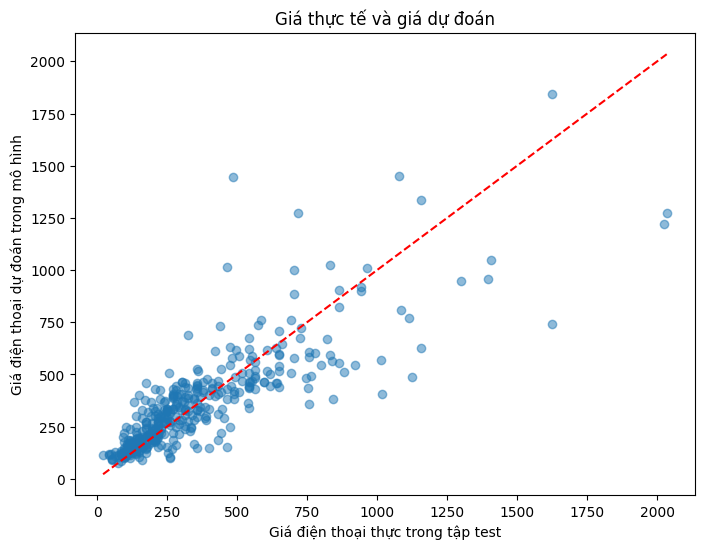

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')
plt.title("Giá thực tế và giá dự đoán")
plt.xlabel("Giá điện thoại thực trong tập test")
plt.ylabel("Giá điện thoại dự đoán trong mô hình")
plt.show()

### Gradient Boosting

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 5, 7]
}

# Khởi tạo mô hình
gradient_boosting_model = GradientBoostingRegressor(random_state=42)

# Sử dụng grid_search cho bài toán
grid_search = GridSearchCV(estimator=gradient_boosting_model, param_grid=param_grid,
                           cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_prep, y_train)

# Parameter của mô hình
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", -grid_search.best_score_)

# Đánh giá mô hình
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_prep)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error on Test Set:", mse)
print("Root Mean Squared Error on Test Set:", rmse)
print("R² Score on Test Set:", r2)

Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best Score: 30094.63279147211
Mean Squared Error on Test Set: 24283.2440310698
Root Mean Squared Error on Test Set: 155.83081861772337
R² Score on Test Set: 0.708879113082377


In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')
plt.title("Giá thực tế và giá dự đoán")
plt.xlabel("Giá điện thoại thực trong tập test")
plt.ylabel("Giá điện thoại dự đoán trong mô hình")
plt.show()

# 6. Kết luận

Qua các thử nghiệm trên ta thấy mô hình Random Forest hiệu quả nhất với rmse là 136 và R2 là 0.76

# 7. Mở rộng

## Độ quan trọng của các feature với mô hình

Sử dụng Random Forest để tính Feature Importances

In [ ]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

random_forest_model = RandomForestRegressor(random_state=42)


random_forest_model.fit(X_train_prep, y_train)

importances = random_forest_model.feature_importances_



sorted_indices = np.argsort(importances)[::-1]
feature_names = X_train.columns
sorted_features = np.array(feature_names)[sorted_indices]
sorted_importances = importances[sorted_indices]

# Print top 10 feature importances
print("Top 10 Feature Importances:")
for i in range(10):
    print(f"{i+1}. {sorted_features[i]}: {sorted_importances[i]}")

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_importances)), sorted_importances, align='center')
plt.xticks(range(len(sorted_importances)), sorted_features, rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.title('Feature Importances')
plt.show()
